### 此專案來套用所提出之EVCC模型於 PEWC 資料###

In [1]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(42)

def read_rul_data_PEWC(filepath, default_spd=0, default_trq=0, default_pwr=0, default_eff=0):

    data_read = None
    # 檢查檔案是否存在
    if os.path.exists(filepath):
        if filepath.endswith('.parquet'):
            df_loaded = pd.read_parquet(filepath)
            tt=np.array(df_loaded["Voltage alpha"].iloc[0])
            data_read = {
                "Unix Time": df_loaded["Unix Time"].iloc[0],
                "Speed": [df_loaded["Speed"].iloc[0]],
                "Torque": [df_loaded["Torque"].iloc[0]],
                "Power": [df_loaded["Power"].iloc[0]],
                "Efficiency": [df_loaded["Efficiency"].iloc[0]],
                "vibration rms": [df_loaded["vibration rms"].iloc[0]] if "vibration rms" in df_loaded else [],
                "Voltage alpha": np.array([df_loaded["Voltage alpha"].iloc[0]]).T,
                "Voltage beta": np.array([df_loaded["Voltage beta"].iloc[0]]).T,
                "Current alpha": np.array([df_loaded["Current alpha"].iloc[0]]).T,  # 轉為 List
                "Current beta": np.array([df_loaded["Current beta"].iloc[0]]).T,
                "vibration data": np.array([df_loaded["vibration data"].iloc[0]]).T if "vibration rms" in df_loaded else [],
            }
        elif filepath.endswith('.csv'):
            # csv read code version
            # read time stamp from first line
            with open(filepath, "r") as file:
                first_line = file.readline().strip()  # 讀取第一行並去掉換行符
            unix_time = first_line.split(",")[1]  # 取第二個欄位 (1736773960)

            # read rest of the data
            # df_loaded=pd.read_csv(filepath, skiprows=1, names=["V_alpha", "V_beta", "I_alpha", "I_beta"])
            df_loaded = pd.read_csv(filepath, skiprows=1)

            data_read = {
                "Unix Time": unix_time,
                "Speed":    [default_spd],
                "Torque":   [default_trq],
                "Power":    [default_pwr],
                "Efficiency": [default_eff],
                "Voltage alpha": df_loaded["V_alpha"].to_numpy(),
                "Voltage beta": df_loaded["V_beta"].to_numpy(),
                "Current alpha":df_loaded["I_alpha"].to_numpy(),
                "Current beta": df_loaded["I_beta"].to_numpy(),
                "vibration rms": [0],
            }
        else:
            print(f"Unsupported file format: {filepath}")
            return data_read


    else:
        print(f"檔案 {filepath} 不存在，請確認檔案路徑。")
    return data_read



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Create ccae model

In [2]:
from datetime import datetime
import json


sequence_length=512
future_length=512
model_folder_path = r'NTU_rul_models\CCAE_models\PEWC'
model_name = f'0822_multiscale_CCAE_Base{sequence_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

def build_cnn_multi_branch_ae(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True,
    # 第一層（分支前）設定
    first_kernel_size=64,      # 第一層 kernel size
    first_layer_filters=None,  # 若為 None，預設用 base_filters
    first_stride=1,            # 第一層 stride（可自訂）
    # 分支 kernels（每個分支全程沿用自己的 k）
    first_branch_kernels=(3, 5, 7),
    # 既有參數
    base_filters=32,
    blocks=3,
    decay=0.5,
    filters_per_block=None,
    # 反捲積（還原第一層 stride）kernel，預設沿用 first_kernel_size
    deconv_kernel_size=None
):
    """
    - Stem：Conv1D(filters=first_layer_filters, kernel_size=first_kernel_size, strides=first_stride, padding='same')
    - Encoder（多分支）：各分支全程用自己的 k；每層 strides=2
    - Bottleneck：Conv1D(k, stride=1)
    - Decoder（多分支）：UpSampling(2)+Conv1D(k, stride=1)
    - Merge 後：只做 1x1 Conv 融合（已移除 3x1 fusion conv）
    - 還原第一層 stride：以「每通道 Conv1DTranspose」(groups=channels, stride=first_stride)
    - **不再強制裁切輸出長度**
    """
    from tensorflow.keras.layers import (
        Input, Concatenate, Conv1D, Dense, UpSampling1D, RepeatVector
    )
    from tensorflow.keras.models import Model

    try:
        from tensorflow.keras.layers import Conv1DTranspose
    except Exception as e:
        raise ImportError(
            "需要 tf.keras.layers.Conv1DTranspose（建議 TF/Keras 2.15+/Keras3）。"
        ) from e

    assert blocks >= 1, "blocks 必須 >= 1"
    assert first_stride >= 1 and int(first_stride) == first_stride, "first_stride 必須為正整數"

    if filters_per_block is not None:
        assert len(filters_per_block) >= blocks, "filters_per_block 長度需 >= blocks"
        f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
    else:
        f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

    if deconv_kernel_size is None:
        deconv_kernel_size = first_kernel_size

    # === Series Inputs ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        inputs.append(Input(shape=(sequence_length, input_dim), name=f'series_{idx}'))
    series_input = inputs[0] if len(inputs) == 1 else Concatenate(axis=-1, name='series_input_concat')(inputs)

    # === Condition inputs ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === (Optional) repeat condition and concat ===
    x_in = series_input
    if iscondition:
        repeated_condition = RepeatVector(sequence_length, name="cond_repeat")(merged_condition)
        x_in = Concatenate(axis=-1, name='series_with_condition')([x_in, repeated_condition])

    # === Stem：Conv1D(k=first_kernel_size, s=first_stride) ===
    if first_layer_filters is None:
        first_layer_filters = base_filters
        # 基礎分支
    stem = Conv1D(
        filters=first_layer_filters,
        kernel_size=first_kernel_size,
        strides=first_stride,
        padding='same',
        activation='relu',
        name=f'stem_conv_k{first_kernel_size}_s{first_stride}'
    )(x_in)

    # === 每個分支一路用自己的 k；encoder strides=2，decoder 上採樣 2 ===
    def cnn_branch(x, k, name_prefix):
        z = x
        for b in range(blocks):
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_enc_c{b+1}_k{k}_s2'
            )(z)
            z = MaxPooling1D(pool_size=2, name=f'{name_prefix}_enc_p{b+1}')(z)
            
        # z = Conv1D(
        #     filters=f_list[-1], kernel_size=k, strides=1,
        #     padding='same', activation='relu',
        #     name=f'{name_prefix}_bottleneck_k{k}'
        # )(z)
        
        for b in reversed(range(blocks)):
            z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}_x2')(z)
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_dec_c{blocks-b}_k{k}'
            )(z)
        return z

    branch_outputs = [cnn_branch(stem, k, name_prefix=f'branch_k{k}') for k in first_branch_kernels]

    merged = Concatenate(axis=-1, name='decoder_branches_concat')(branch_outputs)

    # === 只保留 1x1 融合層 ===
    fuse_width = max(f_list[0], first_layer_filters, base_filters)
    fused = Conv1D(fuse_width, 1, padding='same', activation='relu', name='fusion_conv1x1')(merged)

    # === 每通道 Conv1DTranspose 還原第一層 stride ===
    if first_stride > 1:
        fused = Conv1DTranspose(
            filters=fuse_width,
            kernel_size=deconv_kernel_size,
            strides=first_stride,
            padding='same',
            activation='linear',
            groups=fuse_width,  # depthwise transpose
            name=f'undo_first_stride_deconv_dw_k{deconv_kernel_size}_s{first_stride}'
        )(fused)

    # === Output per channel ===
    output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(fused)
                   for idx, dim in enumerate(input_dim_list)]

    model = Model(
        inputs=inputs + [condition_input_1, condition_input_2],
        outputs=output_list,
        name=(f'CNN_MultiBranch_AE_{series_input.shape[-1]}in_{len(output_list)}out_'
              f'b{blocks}_stemK{first_kernel_size}_s{first_stride}_deconvK{deconv_kernel_size}_'
              f'K{len(first_branch_kernels)}_perBranchK_fuse1x1_noCrop')
    )
    return model


WD_length=64
WD_stride=4
branch_kernels=(3, 5, 7)
enc_depth=3
encoder_decay_rate=0.5

# VI model rul2 based 
my_model_V_in_I_out_PEWC_rul2=  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_nocond_VI',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata_rul2.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

# II model rul2 based 
my_model_I_in_I_out_PEWC_rul2 =  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata_rul2.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
# VI model rul2 based 
my_model_V_in_I_out_PEWC_rul5=  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_nocond_VI',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata_rul5.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
# II model rul5 based
my_model_I_in_I_out_PEWC_rul5 =  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata_rul5.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    




print("All Model saved and loaded successfully.")
print(f"my_model_V_in_V_out parameters: {my_model_V_in_I_out_PEWC_rul2.count_params()}")
print(f"my_model_I_in_I_out parameters: {my_model_I_in_I_out_PEWC_rul2.count_params()}")

All Model saved and loaded successfully.
my_model_V_in_V_out parameters: 108722
my_model_I_in_I_out parameters: 108722


資料前處理

In [3]:
import re
import shutil
from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt
import re
def extract_number(path):
    # 用正則抓取 parquet 前面的數字
    match = re.search(r'_(\d+)\.parquet$', path)
    return int(match.group(1)) if match else -1

def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

# 均勻切分函式 (驗證用)
def data_interval_augmentation(raw_data, sequence_length, augmen_sample_number=5, future_length=64):
    """
    以等距起點切分固定長度序列（不隨機），並可指定切分數量。
    
    raw_data: shape (n, d)
    sequence_length: 視窗長度（滑動窗大小）
    num_samples: 期望切分的樣本數（會自動上限為最大可切數）

    回傳:
        final_data: shape (num_samples_eff, sequence_length, d)
    """
    n = len(raw_data)
    if sequence_length <= 0:
        raise ValueError("sequence_length 必須為正整數")
    if n < sequence_length:
        raise ValueError("資料長度不足以切出任何序列樣本")
    if augmen_sample_number <= 0:
        raise ValueError("num_samples 必須為正整數")

    # 最大可切的起點數（= 可切的樣本上限）
    max_possible = n - sequence_length + 1

    # 若要求超過上限，截到上限
    num_samples_eff = min(augmen_sample_number, max_possible)

    # 等距產生起點（含 0 與 max_possible-1）
    if num_samples_eff == 1:
        start_indices = np.array([0], dtype=int)
    else:
        step = (max_possible - 1) / (num_samples_eff - 1)
        start_indices = np.round(np.arange(num_samples_eff) * step).astype(int)
        start_indices = np.clip(start_indices, 0, max_possible - 1)

    # 依起點切片
    samples_list = [raw_data[s:s + sequence_length] for s in start_indices]
    final_data = np.array(samples_list)

    return final_data

def split_train_val_files(Normal_subfolders, test_size=0.2):
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

def copy_val_files_to_validation(val_files, validation_folder_path):
    for file_path in val_files:
        # 取得原始檔案所在的資料夾名稱 (例如 "class1", "class2")
        class_name = os.path.basename(os.path.dirname(file_path))
        # 在 validation 資料夾下建立對應子資料夾
        class_folder = os.path.join(validation_folder_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        # 複製檔案到對應子資料夾
        shutil.copy(file_path, class_folder)

def estimate_torque(data_read, speed_v=3530, debug=False):

    """
    Estimate the motor torque based on voltage and current inputs.
    :param v_a_raw: Voltage alpha component
    :param v_b_raw: Voltage beta component
    :param i_alpha: Current alpha component
    :param i_beta: Current beta component
    :param speed_v: Motor speed in rpm (default: 900)
    :param debug: Boolean flag to enable debugging plots (default: False)
    :return: Estimated torque array
    """

    v_a_raw = np.array(data_read["Voltage alpha"])
    v_c_raw = np.array(data_read["Voltage beta"])
    i_alpha = np.array(data_read["Current alpha"])
    i_beta  = np.array(data_read["Current beta"])

    # offset calibration
    v_a_raw = v_a_raw - np.mean(v_a_raw)
    v_c_raw = v_c_raw - np.mean(v_c_raw)
    i_alpha = i_alpha - np.mean(i_alpha)
    i_beta = i_beta - np.mean(i_beta)


   
    # Preprocess the voltage data, transform the data to alpha-beta frame
    v_alpha = v_a_raw
    v_beta = (-v_c_raw + v_a_raw - v_c_raw) / np.sqrt(3)
    
    # back to wrong abc 
    v_a=v_alpha
    v_b=-v_alpha / 2 + v_beta * np.sqrt(3) / 2
    v_c=-v_alpha / 2 - v_beta * np.sqrt(3) / 2
    
    i_ab= i_alpha
    i_bc= -i_alpha / 2 + i_beta * np.sqrt(3) / 2
    i_ca= -i_alpha / 2 - i_beta * np.sqrt(3) / 2



    def delta_to_y_current(I_ab, I_bc, I_ca):
        """
        將 delta 接法三相電流轉換為虛擬 Y 接法電流。
        參數:
            I_ab, I_bc, I_ca: np.array 或 float，a->b, b->c, c->a 的相電流
        回傳:
            i_a, i_b, i_c: Y 等效相電流
        """
        i_a = I_ab - I_ca
        i_b = I_bc - I_ab
        i_c = I_ca - I_bc
        return i_a, i_b, i_c

    def delta_to_y_voltage(V_ab, V_bc, V_ca):
        """
        將 delta 接法三相電壓轉換為虛擬 Y 接法電壓。
        參數:
            V_ab, V_bc, V_ca: np.array 或 float，ab, bc, ca 的相間電壓
        回傳:
            v_a, v_b, v_c: Y 等效相電壓
        """
        v_a = (2/3)*V_ab - (1/3)*V_bc - (1/3)*V_ca
        v_b = (2/3)*V_bc - (1/3)*V_ca - (1/3)*V_ab
        v_c = (2/3)*V_ca - (1/3)*V_ab - (1/3)*V_bc
        return v_a, v_b, v_c

    def clarke_transform(a, b, c):
        """
        Clarke Transform: 將三相轉換成 alpha-beta 軸
        參數:
            a, b, c: Y 相電壓或電流
        回傳:
            alpha, beta
        """
        T = (2/3) * np.array([
            [1, -0.5, -0.5],
            [0,  np.sqrt(3)/2, -np.sqrt(3)/2]
        ])
        abc = np.array([a, b, c])
        alpha_beta = T @ abc.squeeze()
        return alpha_beta[0], alpha_beta[1]

    def delta_to_clarke(I_ab, I_bc, I_ca, V_ab, V_bc, V_ca):
        """
        將 delta 接法電壓與電流轉換為 Clarke alpha-beta 表示
        參數:
            I_ab, I_bc, I_ca: 相電流
            V_ab, V_bc, V_ca: 相電壓
        回傳:
            I_alpha, I_beta, V_alpha, V_beta
        """
        i_a, i_b, i_c = delta_to_y_current(I_ab, I_bc, I_ca)
        v_a, v_b, v_c = delta_to_y_voltage(V_ab, V_bc, V_ca)
        I_alpha, I_beta = clarke_transform(i_a, i_b, i_c)
        V_alpha, V_beta = clarke_transform(v_a, v_b, v_c)
        return I_alpha, I_beta, V_alpha, V_beta

    i_alpha, i_beta, v_alpha, v_beta = delta_to_clarke(i_ab, i_bc, i_ca, (v_a-v_b), ( (v_b-v_c)), (v_c-v_a))
    
    class EMF:
        def __init__(self):
            self.Alpha = 0.0
            self.Beta = 0.0
            self.Alpha_last = 0.0
            self.Beta_last = 0.0
            self.Alpha_LPF = 0.0
            self.Beta_LPF = 0.0
            self.Alpha_LPF_last = 0.0
            self.Beta_LPF_last = 0.0

    def emf_to_lpf(sampling_time, lpf_radius, emf_obj):
        lpf_radius_t = lpf_radius * sampling_time
        emf_coef1 = sampling_time / (lpf_radius_t + 2)
        emf_coef2 = (lpf_radius_t - 2) / (lpf_radius_t + 2)

        emf_obj.Alpha_LPF = emf_coef1 * (emf_obj.Alpha_last + emf_obj.Alpha) - emf_coef2 * emf_obj.Alpha_LPF_last
        emf_obj.Beta_LPF = emf_coef1 * (emf_obj.Beta_last + emf_obj.Beta) - emf_coef2 * emf_obj.Beta_LPF_last

        emf_obj.Alpha_last = emf_obj.Alpha
        emf_obj.Beta_last = emf_obj.Beta

        emf_obj.Alpha_LPF_last = emf_obj.Alpha_LPF
        emf_obj.Beta_LPF_last = emf_obj.Beta_LPF

    def flux_comp(omega_e, lpf_radius):
        if np.abs(omega_e) < 1:
            mag_comp = 1.0
        else:
            mag_comp = np.abs(omega_e) / np.sqrt(omega_e ** 2 + lpf_radius ** 2)

        phase_comp = -57.29578 * np.arctan2(lpf_radius, omega_e) / 360  # Degree to radians conversion

        return mag_comp, phase_comp

    # Compute necessary parameters
    fs = 10000  # Sampling rate
    flux_rs = 0.06  # Motor stator resistance
    tsim = 1 / fs  # Time step

    we = (speed_v / 60) * (np.pi * 2) # electrical angular velocity
    coef = 0.2
    cross_freq = 15.0

    intgr_bw_f = max((we / (np.pi * 2)) * coef, cross_freq)
    fast_wc = intgr_bw_f * (np.pi * 2)

    # Process each time step
    emf1 = EMF()
    alpha_lpf_values, beta_lpf_values = [], []
    alpha_raw_values, beta_raw_values = [], []

    for va, vb, ia, ib in zip(v_alpha, v_beta, i_alpha, i_beta):
        emf1.Alpha = va - (ia * flux_rs)
        emf1.Beta = vb - (ib * flux_rs)
        alpha_raw_values.append(emf1.Alpha)
        beta_raw_values.append(emf1.Beta)
        emf_to_lpf(tsim, fast_wc, emf1)
        alpha_lpf_values.append(emf1.Alpha_LPF)
        beta_lpf_values.append(emf1.Beta_LPF)

    # Flux compensation
    mag_comp2, phase_comp2 = flux_comp(we, fast_wc)

    # Apply phase and magnitude compensation
    alpha_compensated_values, beta_compensated_values = [], []
    for alpha, beta in zip(alpha_lpf_values, beta_lpf_values):
        ds = alpha * mag_comp2
        qs = beta * mag_comp2
        angle = phase_comp2
        sine, cosine = np.sin(angle), np.cos(angle)
        alpha_transformed = ds * cosine - qs * sine
        beta_transformed = qs * cosine + ds * sine
        alpha_compensated_values.append(alpha_transformed)
        beta_compensated_values.append(beta_transformed)

    # Torque estimation
    torque_v = 1.5 * 2 * ((np.array(alpha_compensated_values) * i_beta) - (np.array(beta_compensated_values) * i_alpha))
    torque_avg = np.mean(np.abs(torque_v[-500:]))
    # Power and efficiency estimation
    Power_M= torque_avg*speed_v*2*np.pi/60
    Power_E = 1.5*np.mean((v_alpha * i_alpha + v_beta * i_beta))
    efficiency = Power_M / Power_E * 100
    power_sts = {
        'Power_M': Power_M,
        'Power_E': Power_E,
        'Efficiency': efficiency,
        'Efficiency_alarm': int(efficiency < 90)
    }

    if debug :
        date_time=pd.to_datetime(data_read["Unix Time"], unit='s').strftime('%Y-%m-%d %H:%M:%S')

        print("Estimated Torque:", np.mean(torque_v[-Motor_global_vars.data_length:]))
        # print result
        for key, value in power_sts.items():
            print(f"{key}: {value}")
        time = np.arange(len(v_alpha)) * tsim

        # plot the flux values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_compensated_values, label='Flux Alpha')
        plt.plot(time, beta_compensated_values, label='Flux Beta ')
        plt.xlabel('Time (s)')
        plt.ylabel('Flux Values')
        plt.legend()
        plt.title('Flux Values'+date_time)
        plt.grid()
        plt.show(block=False)

        # plot the voltage values
        plt.figure(figsize=(10, 5))
        plt.plot(time, v_alpha, label='Voltage Beta (raw)')
        plt.plot(time, v_beta, label='Voltage Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage Values')
        plt.legend()
        plt.title('Voltage Values')
        plt.grid()
        plt.show(block=False)

        # plot the current values
        plt.figure(figsize=(10, 5))
        plt.plot(time, i_alpha, label='Current Alpha (raw)')
        plt.plot(time, i_beta, label='Current Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Current Values')
        plt.legend()
        plt.title('Current Values')
        plt.grid()
        plt.show(block=False)

        # plot the EMF values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_raw_values, label='EMF Alpha (raw)')
        plt.plot(time, beta_raw_values, label='EMF Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('EMF Values')
        plt.legend()
        plt.title('EMF Values')
        plt.grid()
        plt.show(block=False)

        # plot torque estimation
        plt.figure(figsize=(10, 5))
        plt.plot(time, torque_v, label='Torque (Voltage Model)')
        if len(torque_v) > 2500:
            plt.plot(time[2250:2500], torque_v[2250:2500], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[2250:2500])
        else:
            plt.plot(time[-500:], torque_v[-500:], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[-500:])
            
        plt.axhline(y=torque_avg, color='k', linestyle='--', label='Averaged torque')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (N.m)')
        plt.legend()
        plt.title(f'Torque Estimation :{torque_avg:.2f} (N.m)')
        plt.grid()
        plt.show(block=False)

        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('EMF Alpha (Raw)', color='tab:blue')
        ax1.plot(time, alpha_raw_values, label='EMF Alpha (Raw)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('EMF Alpha (Filtered)', color='tab:red')
        # ax2.plot(time, alpha_lpf_values, label='EMF Alpha (Filtered)', color='tab:red')
        ax2.plot(time, alpha_compensated_values, label='EMF Alpha (Compensated)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

        plt.title('EMF Alpha - Raw vs Filtered')
        plt.grid()
        plt.show(block=False)
    # return the torque value and the estimated flux
    return torque_v, alpha_compensated_values, beta_compensated_values, v_alpha, v_beta, power_sts

rul2_dataset_path="D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2"
rul5_dataset_path="D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5"

# 取出 rul2_dataset_path 中的所有 file 名稱
rul2_files = [f for f in os.listdir(rul2_dataset_path) if os.path.isfile(os.path.join(rul2_dataset_path, f))]
# 將 rul2_dataset_path 路徑加回 rul2_files，得到完整路徑列表
rul2_files = [os.path.join(rul2_dataset_path, f) for f in rul2_files]
rul2_files = sorted(rul2_files, key=extract_number)
print(rul2_files[0:10])

rul5_files = [f for f in os.listdir(rul5_dataset_path) if os.path.isfile(os.path.join(rul5_dataset_path, f))]
# 將 rul5_dataset_path 路徑加回 rul5_files，得到完整路徑列表
rul5_files = [os.path.join(rul5_dataset_path, f) for f in rul5_files]
rul5_files = sorted(rul5_files, key=extract_number)

print(rul5_files[0:10])

print(f'rul2 file number: {len(rul2_files)}')
print(f'rul5 file number: {len(rul5_files)}')


['D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2754.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2755.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2756.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2757.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2758.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2759.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2760.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_all\\RUL_2\\RUL_Data_2_2761.parquet', 'D:\\Pycharm_conda_projects\\PEWC data analysis\\PEWC dataset\\PEWC_raw_data_al

In [4]:

training_file_numbers=1000 # 取前100個做為訓練使用
train_files, val_files = train_test_split(rul2_files[0:training_file_numbers], test_size=0.2)
augmen_sample_number=200
def get_augment_data_from_files(files, augmen_sample_number=200):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data_PEWC(file_path)
            
            df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2 
            torque, _, _, v_alpha, v_beta, power_sts = estimate_torque(df, debug=False)

            voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
            voltage_beta= np.array(df["Voltage beta"]).squeeze()
            current_alpha= np.array(df["Current alpha"]).squeeze()
            current_beta= np.array(df["Current beta"]).squeeze()

            
            if len(torque) > 2500:
                if len(torque) == 4000:
                    torque_avg = np.mean(np.abs(torque[-2000:]))
                else :
                    torque_avg = np.mean(np.abs(torque[2250:2500]))
            else:
                torque_avg = np.mean(np.abs(torque[-500:]))
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque_avg)
            
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)

    # 隨機打亂訓練資料
    indices = np.random.permutation(train_signals.shape[0])
    train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
            
    augment_data = {
        "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "torque_array": torque_array
    }
    return augment_data

rul2_training_data=get_augment_data_from_files(train_files, augmen_sample_number=200)
past_voltages = rul2_training_data["input_signals"][:, :, 0:2]
past_currents = rul2_training_data["input_signals"][:, :, 2:4]
past_voltages_normalized = rul2_training_data["input_signals_normalized"][:, :, 0:2]
past_currents_normalized = rul2_training_data["input_signals_normalized"][:, :, 2:4]
torque_array = rul2_training_data["torque_array"]

print(f"train_input_signals shape: {past_voltages_normalized.shape}")
print(f"torque_array shape: {torque_array.shape}")

train_files_rul5, val_files_rul5 = train_test_split(rul5_files[0:training_file_numbers], test_size=0.2)
augmen_sample_number=200
rul5_training_data=get_augment_data_from_files(train_files_rul5, augmen_sample_number=200)
past_voltages_rul5 = rul5_training_data["input_signals"][:, :, 0:2]
past_currents_rul5 = rul5_training_data["input_signals"][:, :, 2:4]
past_voltages_normalized_rul5 = rul5_training_data["input_signals_normalized"][:, :, 0:2]
past_currents_normalized_rul5 = rul5_training_data["input_signals_normalized"][:, :, 2:4]
torque_array_rul5 = rul5_training_data["torque_array"]

print(f"train_input_signals shape: {past_voltages_normalized_rul5.shape}")
print(f"torque_array shape: {torque_array_rul5.shape}")

train_input_signals shape: (160000, 512, 2)
torque_array shape: (160000, 1)
train_input_signals shape: (160000, 512, 2)
torque_array shape: (160000, 1)


訓練 Vin Iout 模型

1/1 [==============================] - 11s 11s/step
Model structures passed, start training...
開始訓練...
Epoch 1/50
1125/1125 [==============================] - 18s 14ms/step - loss: 0.0084 - val_loss: 6.2470e-04 - lr: 0.0010
Epoch 2/50
1125/1125 [==============================] - 15s 14ms/step - loss: 6.2779e-04 - val_loss: 6.3303e-04 - lr: 0.0010
Epoch 3/50
1125/1125 [==============================] - 21s 19ms/step - loss: 5.7931e-04 - val_loss: 4.9865e-04 - lr: 0.0010
Epoch 4/50
1125/1125 [==============================] - 21s 19ms/step - loss: 5.6019e-04 - val_loss: 4.3847e-04 - lr: 0.0010
Epoch 5/50
1125/1125 [==============================] - 22s 20ms/step - loss: 5.3940e-04 - val_loss: 5.5978e-04 - lr: 0.0010
Epoch 6/50
1125/1125 [==============================] - 21s 19ms/step - loss: 5.2708e-04 - val_loss: 4.4869e-04 - lr: 0.0010
Epoch 7/50
1125/1125 [==============================] - 21s 18ms/step - loss: 5.1031e-04 - val_loss: 4.5717e-04 - lr: 0.0010
Epoch 8/50
1123/1125 [====

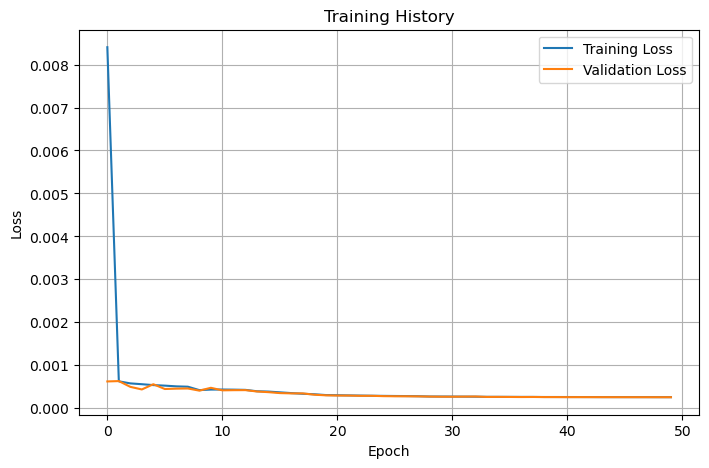

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_V_in_I_out_PEWC_rul2)

# 測試模型結構是否正確 (無condition torque 為假輸入)
my_model_V_in_I_out_PEWC_rul2.predict([ past_voltages[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_V_in_I_out_PEWC_rul2.save(os.path.join(model_path, model_name + '_VI.keras'))
my_model_V_in_I_out_PEWC_rul2= load_model(os.path.join(model_path, model_name + '_VI.keras'))
print("Model structures passed, start training...")


with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_V_in_I_out_PEWC_rul2.fit(
        x=[past_voltages_normalized, torque_array, torque_array], 
        y=past_currents_normalized,
        batch_size=128,
        epochs=50,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

# save model 
my_model_V_in_I_out_PEWC_rul2.save(os.path.join(model_path, model_name + '_VI_rul2.keras'))

metadata = {
    "model_name": model_name+'_VI_rul2',
    "sequence_length": sequence_length,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_VI_metadata_rul2.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)


1/1 [==============================] - 1s 562ms/step
Model structures passed, start training...
(160000, 512, 2)
開始訓練...
Epoch 1/30
1125/1125 [==============================] - 28s 22ms/step - loss: 0.0092 - val_loss: 5.0857e-04 - lr: 0.0010
Epoch 2/30
1125/1125 [==============================] - 25s 22ms/step - loss: 5.0656e-04 - val_loss: 4.4981e-04 - lr: 0.0010
Epoch 3/30
1125/1125 [==============================] - 21s 19ms/step - loss: 4.7499e-04 - val_loss: 3.5581e-04 - lr: 0.0010
Epoch 4/30
1125/1125 [==============================] - 21s 18ms/step - loss: 4.4661e-04 - val_loss: 3.3155e-04 - lr: 0.0010
Epoch 5/30
1125/1125 [==============================] - 20s 18ms/step - loss: 4.0165e-04 - val_loss: 5.0174e-04 - lr: 0.0010
Epoch 6/30
1125/1125 [==============================] - 22s 19ms/step - loss: 3.5017e-04 - val_loss: 5.8373e-04 - lr: 0.0010
Epoch 7/30
1125/1125 [==============================] - 23s 20ms/step - loss: 3.2150e-04 - val_loss: 3.1499e-04 - lr: 0.0010
Epoch 8/

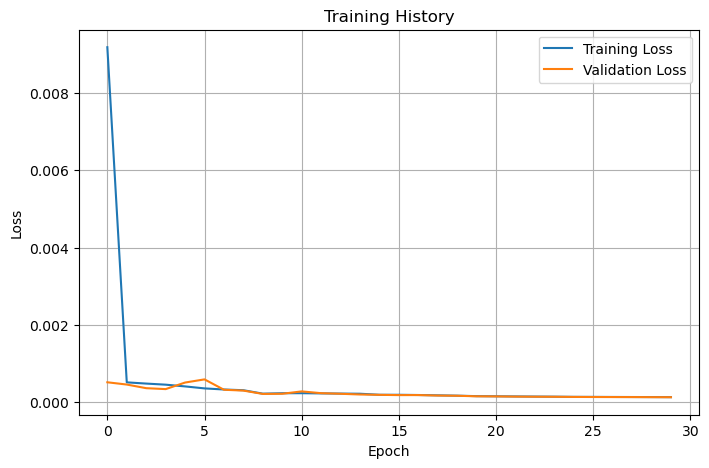

In [6]:
def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_I_in_I_out_PEWC_rul2)

# 測試模型結構是否正確 (無condition torque 為假輸入)
my_model_I_in_I_out_PEWC_rul2.predict([ past_currents_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_I_in_I_out_PEWC_rul2.save(os.path.join(model_path, model_name + '_II_rul2.keras'))
my_model_I_in_I_out_PEWC_rul2= load_model(os.path.join(model_path, model_name + '_II_rul2.keras'))
print("Model structures passed, start training...")

print(past_currents_normalized.shape)
with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_I_in_I_out_PEWC_rul2.fit(
        x=[past_currents_normalized, torque_array, torque_array], 
        y=past_currents_normalized,
        batch_size=128,
        epochs=30,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

# save model 
my_model_I_in_I_out_PEWC_rul2.save(os.path.join(model_path, model_name + '_II_rul2.keras'))

metadata = {
    "model_name": model_name+'_II_rul2',
    "sequence_length": sequence_length,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_II_metadata_rul2.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


訓練 基於 RUL5 之VinIout 模型

1/1 [==============================] - 0s 447ms/step
Model structures passed, start training...
開始訓練...
Epoch 1/50
1125/1125 [==============================] - 28s 22ms/step - loss: 0.0080 - val_loss: 5.0802e-04 - lr: 0.0010
Epoch 2/50
1125/1125 [==============================] - 22s 19ms/step - loss: 4.8410e-04 - val_loss: 4.1512e-04 - lr: 0.0010
Epoch 3/50
1125/1125 [==============================] - 22s 19ms/step - loss: 4.6565e-04 - val_loss: 5.8916e-04 - lr: 0.0010
Epoch 4/50
1125/1125 [==============================] - 23s 21ms/step - loss: 4.5851e-04 - val_loss: 3.6737e-04 - lr: 0.0010
Epoch 5/50
1125/1125 [==============================] - 22s 20ms/step - loss: 4.3927e-04 - val_loss: 5.2884e-04 - lr: 0.0010
Epoch 6/50
1125/1125 [==============================] - 21s 19ms/step - loss: 4.2442e-04 - val_loss: 4.5646e-04 - lr: 0.0010
Epoch 7/50
1125/1125 [==============================] - 21s 19ms/step - loss: 4.1321e-04 - val_loss: 3.7488e-04 - lr: 0.0010
Epoch 8/50
1125/1125 [===

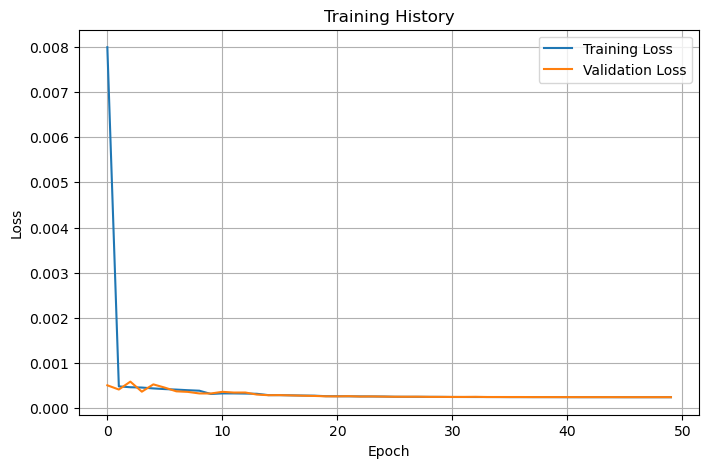

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam


def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_V_in_I_out_PEWC_rul5)

# 測試模型結構是否正確 (無condition torque 為假輸入)
my_model_V_in_I_out_PEWC_rul5.predict([ past_voltages[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_V_in_I_out_PEWC_rul5.save(os.path.join(model_path, model_name + '_VI_rul5.keras'))
my_model_V_in_I_out_PEWC_rul5= load_model(os.path.join(model_path, model_name + '_VI_rul5.keras'))
print("Model structures passed, start training...")


with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_V_in_I_out_PEWC_rul5.fit(
        x=[past_voltages_normalized_rul5, torque_array_rul5, torque_array_rul5], 
        y=past_currents_normalized_rul5,
        batch_size=128,
        epochs=50,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


# save model 
my_model_V_in_I_out_PEWC_rul5.save(os.path.join(model_path, model_name + '_VI_rul5.keras'))

metadata = {
    "model_name": model_name+'_VI_rul5',
    "sequence_length": sequence_length,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_VI_rul5_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)


1/1 [==============================] - 0s 478ms/step
Model structures passed, start training...
(160000, 512, 2)
開始訓練...
Epoch 1/30
1125/1125 [==============================] - 35s 28ms/step - loss: 0.0081 - val_loss: 3.3368e-04 - lr: 0.0010
Epoch 2/30
1125/1125 [==============================] - 30s 27ms/step - loss: 3.9398e-04 - val_loss: 3.5898e-04 - lr: 0.0010
Epoch 3/30
1125/1125 [==============================] - 30s 27ms/step - loss: 3.6976e-04 - val_loss: 3.8407e-04 - lr: 0.0010
Epoch 4/30
1125/1125 [==============================] - 30s 26ms/step - loss: 3.6085e-04 - val_loss: 3.5379e-04 - lr: 0.0010
Epoch 5/30
1125/1125 [==============================] - 29s 26ms/step - loss: 3.4625e-04 - val_loss: 2.7154e-04 - lr: 0.0010
Epoch 6/30
1125/1125 [==============================] - ETA: 0s - loss: 3.3058e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1125/1125 [==============================] - 30s 26ms/step - loss: 3.3058e-04 - val_loss: 2.9966e-0

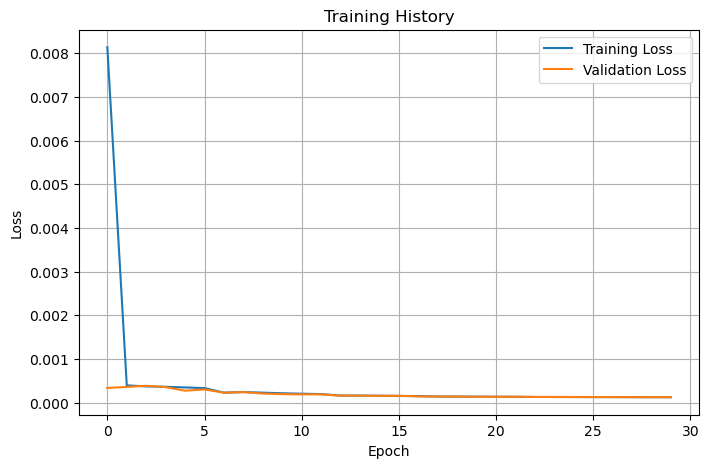

In [8]:
def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_I_in_I_out_PEWC_rul5)

# 測試模型結構是否正確 (無condition torque 為假輸入)
my_model_I_in_I_out_PEWC_rul5.predict([ past_currents_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_I_in_I_out_PEWC_rul5.save(os.path.join(model_path, model_name + '_II_rul5.keras'))
my_model_I_in_I_out_PEWC_rul5= load_model(os.path.join(model_path, model_name + '_II_rul5.keras'))
print("Model structures passed, start training...")

print(past_currents_normalized.shape)
with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_I_in_I_out_PEWC_rul5.fit(
        x=[past_currents_normalized_rul5, torque_array, torque_array], 
        y=past_currents_normalized_rul5,
        batch_size=128,
        epochs=30,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

# save model 
my_model_I_in_I_out_PEWC_rul5.save(os.path.join(model_path, model_name + '_II_rul5.keras'))

metadata = {
    "model_name": model_name+'_II_rul5',
    "sequence_length": sequence_length,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_II_metadata_rul5.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


套用模型

In [9]:
print(rul5_files[0])

D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2754.parquet


## Comparison ##
in time

1/1 [==============================] - 0s 29ms/step


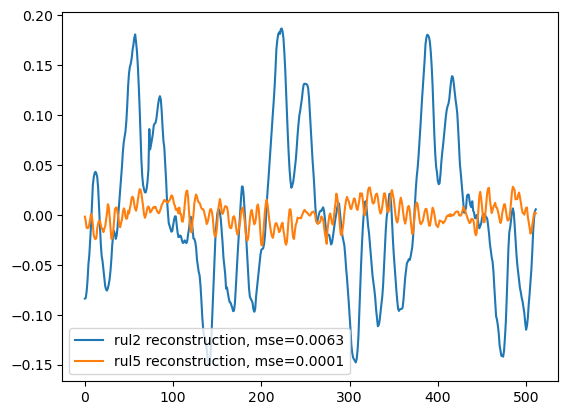

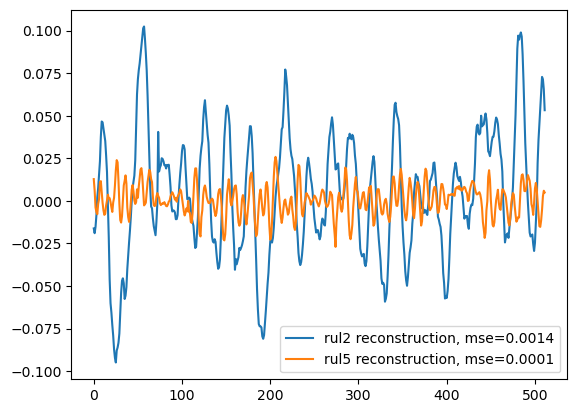

In [10]:
my_model_V_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_VI_rul5.keras'))
my_model_I_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_II_rul5.keras'))
my_model_V_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_VI_rul5.keras'))
my_model_I_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_II_rul5.keras'))
verify_results_rul2_VI = my_model_V_in_I_out_PEWC.predict([ past_voltages_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
verify_results_rul5_VI = my_model_V_in_I_out_PEWC.predict([ past_voltages_normalized_rul5[0:1,:,:], torque_array_rul5[0:1,:], torque_array_rul5[0:1,:]])  
verify_results_rul2_II = my_model_I_in_I_out_PEWC.predict([ past_currents_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
verify_results_rul5_II = my_model_I_in_I_out_PEWC.predict([ past_currents_normalized_rul5[0:1,:,:], torque_array_rul5[0:1,:], torque_array_rul5[0:1,:]])  

# check the reconstruction VI vs II in rul2  
plt.figure()
errorsrul2=past_currents_normalized[0,:,0]-verify_results_rul2_VI[0, :, 0]
errorsrul5=past_currents_normalized_rul5[0,:,0]-verify_results_rul5_VI[0, :, 0]
plt.plot(errorsrul2, label=f'rul2 reconstruction, mse={np.mean(errorsrul2**2):.4f}')
plt.plot(errorsrul5, label=f'rul5 reconstruction, mse={np.mean(errorsrul5**2):.4f}')
plt.legend()

# check the reconstruction result 
plt.figure()
errorsrul2=past_currents_normalized[0,:,0]-verify_results_rul2_II[0, :, 0]
errorsrul5=past_currents_normalized_rul5[0,:,0]-verify_results_rul5_II[0, :, 0]
plt.plot(errorsrul2, label=f'rul2 reconstruction, mse={np.mean((errorsrul2**2)):.4f}')
plt.plot(errorsrul5, label=f'rul5 reconstruction, mse={np.mean((errorsrul5**2)):.4f}')
plt.legend()

In xy plot

In [11]:
# val_data_rul2 = get_augment_data_from_files(val_files, augmen_sample_number=100)

# val_data_rul5 = get_augment_data_from_files(val_files_rul5, augmen_sample_number=100)
my_model_V_in_I_out_PEWC_rul2=load_model(os.path.join(model_path, model_name + '_VI_rul2.keras'))
my_model_V_in_I_out_PEWC_rul5=load_model(os.path.join(model_path, model_name + '_VI_rul5.keras'))
my_model_I_in_I_out_PEWC_rul2=load_model(os.path.join(model_path, model_name + '_II_rul2.keras'))
my_model_I_in_I_out_PEWC_rul5=load_model(os.path.join(model_path, model_name + '_II_rul5.keras'))
testing_file_numbers=100
test_augment_sample_number=10
#驗證及資料
# val_data_rul2 = get_augment_data_from_files(rul2_files[training_file_numbers:training_file_numbers+testing_file_numbers], augmen_sample_number=test_augment_sample_number)
# val_data_rul5 = get_augment_data_from_files(rul5_files[training_file_numbers:training_file_numbers+testing_file_numbers], augmen_sample_number=test_augment_sample_number)

# 測試集資料
val_data_rul2 = get_augment_data_from_files(rul2_files[:training_file_numbers], augmen_sample_number=test_augment_sample_number)
val_data_rul5 = get_augment_data_from_files(rul5_files[:training_file_numbers], augmen_sample_number=test_augment_sample_number)



reconstruction_rul2_VI= my_model_V_in_I_out_PEWC_rul2.predict([val_data_rul2["input_signals_normalized"][:, :, 0:2],
                                                    val_data_rul2["torque_array"],
                                                    val_data_rul2["torque_array"]], batch_size=512)

reconstruction_rul5_VI= my_model_V_in_I_out_PEWC_rul5.predict([val_data_rul5["input_signals_normalized"][:, :, 0:2],
                                                    val_data_rul5["torque_array"],
                                                    val_data_rul5["torque_array"]], batch_size=512)

reconstruction_rul2_II= my_model_I_in_I_out_PEWC_rul2.predict([val_data_rul2["input_signals_normalized"][:, :, 2:4],
                                                    val_data_rul2["torque_array"],
                                                    val_data_rul2["torque_array"]], batch_size=512)

reconstruction_rul5_II= my_model_I_in_I_out_PEWC_rul5.predict([val_data_rul5["input_signals_normalized"][:, :, 2:4],
                                                    val_data_rul5["torque_array"],
                                                    val_data_rul5["torque_array"]], batch_size=512)


reconstruction_errors_rul2_VI= {
            "EMF_alpha_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,2] - reconstruction_rul2_VI[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,3] - reconstruction_rul2_VI[:,:,1])**2, axis=1)
        }
reconstruction_errors_rul5_VI= {
            "EMF_alpha_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,2] - reconstruction_rul5_VI[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,3] - reconstruction_rul5_VI[:,:,1])**2, axis=1)
        }
reconstruction_errors_rul2_II= {
            "EMF_alpha_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,2] - reconstruction_rul2_II[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,3] - reconstruction_rul2_II[:,:,1])**2, axis=1)
        }
reconstruction_errors_rul5_II= {
            "EMF_alpha_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,2] - reconstruction_rul5_II[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,3] - reconstruction_rul5_II[:,:,1])**2, axis=1)
        }


20/20 [==============================] - 1s 17ms/step


{}
{}


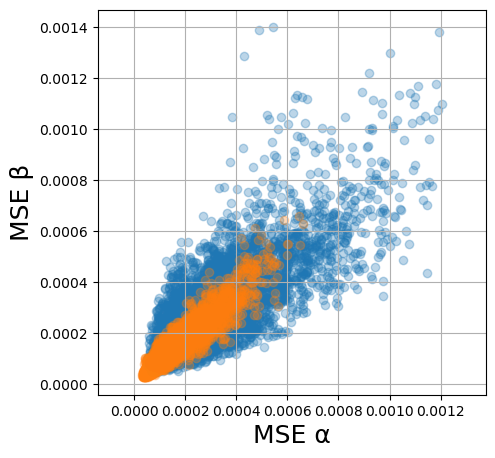

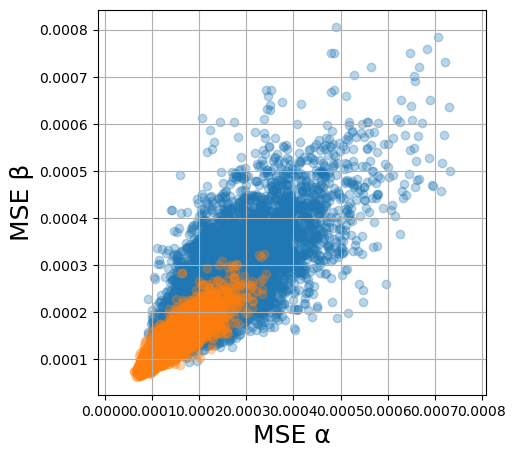

In [12]:
# 計算高斯分布參數
def Guassian_2D_MLE(x, y):
   data = np.stack((x, y), axis=1)
   mean_vector = np.mean(data, axis=0)
   cov_matrix = np.cov(data, rowvar=False)
   return mean_vector, cov_matrix

def Bhattacharyya_distnace_2D(mean_vector1, cov_matrix1, mean_vector2, cov_matrix2):
    # 計算 Bhattacharyya 距離
    
    cov_avg = (cov_matrix1 + cov_matrix2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov_matrix1) * np.linalg.det(cov_matrix2)))
    term2 = 0.125 * (mean_vector2 - mean_vector1).T @ np.linalg.inv(cov_avg) @ (mean_vector2 - mean_vector1)
    return term1 + term2

# BD results 
BD_II= {}
BD_VI = {}

# VI 模型
x_normal_VI_rul2 = reconstruction_errors_rul2_VI["EMF_alpha_MSE"]
y_normal_VI_rul2 = reconstruction_errors_rul2_VI["EMF_beta_MSE"]

outlier_number=2
# 去除離群值
sorted_idx = np.argsort(x_normal_VI_rul2)
selected_idx = sorted_idx[:len(x_normal_VI_rul2)-outlier_number*test_augment_sample_number]
x_normal_VI_rul2 = x_normal_VI_rul2[selected_idx]
y_normal_VI_rul2 = y_normal_VI_rul2[selected_idx]

x_normal_VI_rul5 = reconstruction_errors_rul5_VI["EMF_alpha_MSE"]
y_normal_VI_rul5 = reconstruction_errors_rul5_VI["EMF_beta_MSE"]
# 去除離群值
sorted_idx = np.argsort(x_normal_VI_rul5)
selected_idx = sorted_idx[:len(x_normal_VI_rul5)-outlier_number*test_augment_sample_number]
x_normal_VI_rul5 = x_normal_VI_rul5[selected_idx]
y_normal_VI_rul5 = y_normal_VI_rul5[selected_idx]

# II模型 rul2
x_normal_II_rul2 = reconstruction_errors_rul2_II["EMF_alpha_MSE"]
y_normal_II_rul2 = reconstruction_errors_rul2_II["EMF_beta_MSE"]
# 去除離群值
sorted_idx = np.argsort(x_normal_II_rul2)
selected_idx = sorted_idx[:len(x_normal_II_rul2)-outlier_number*test_augment_sample_number]
x_normal_II_rul2 = x_normal_II_rul2[selected_idx]
y_normal_II_rul2 = y_normal_II_rul2[selected_idx]

# II模型 rul5
x_normal_II_rul5 = reconstruction_errors_rul5_II["EMF_alpha_MSE"]
y_normal_II_rul5 = reconstruction_errors_rul5_II["EMF_beta_MSE"]
# 去除離群值
sorted_idx = np.argsort(x_normal_II_rul5)
selected_idx = sorted_idx[:len(x_normal_II_rul5)-outlier_number*test_augment_sample_number]
x_normal_II_rul5 = x_normal_II_rul5[selected_idx]
y_normal_II_rul5 = y_normal_II_rul5[selected_idx]


plt.figure(figsize=(5, 5))
plt.scatter(x_normal_VI_rul2, y_normal_VI_rul2, label="Normal", color='tab:blue', alpha=0.3)
plt.scatter(x_normal_II_rul2, y_normal_II_rul2, label="Validation", color='tab:orange', alpha=0.3)
plt.xlabel("MSE α", fontsize=18)
plt.ylabel("MSE β", fontsize=18)
plt.grid(True)
plt.axis("equal")   # XY 座標比例一致

plt.figure(figsize=(5, 5))
plt.scatter(x_normal_VI_rul5, y_normal_VI_rul5, label="Normal", color='tab:blue', alpha=0.3)
plt.scatter(x_normal_II_rul5, y_normal_II_rul5, label="Validation", color='tab:orange', alpha=0.3)
plt.xlabel("MSE α", fontsize=18)
plt.ylabel("MSE β", fontsize=18)
plt.grid(True)
plt.axis("equal")   # 各圖自己算範圍，但保持正方形比例


print(BD_VI)
print(BD_II)

In [13]:
# for i in range((10)):
#     print(rul5_files[i])
len(rul5_files)

17967

計算與健康樣本的馬式距離

12/12 [==============================] - 0s 16ms/step


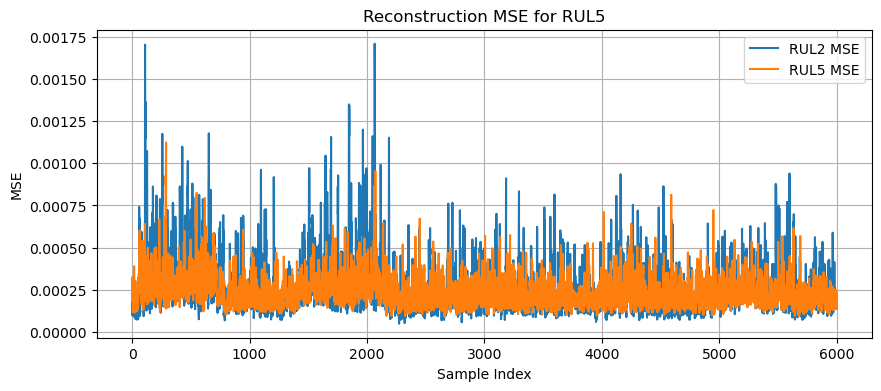

In [14]:
def get_augment_data_from_files_rul(files, augmen_sample_number=5):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data_PEWC(file_path)
            
            df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2 
            torque, _, _, v_alpha, v_beta, power_sts = estimate_torque(df, debug=False)

            voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
            voltage_beta= np.array(df["Voltage beta"]).squeeze()
            current_alpha= np.array(df["Current alpha"]).squeeze()
            current_beta= np.array(df["Current beta"]).squeeze()

            
            if len(torque) > 2500:
                if len(torque) == 4000:
                    torque_avg = np.mean(np.abs(torque[-2000:]))
                else :
                    torque_avg = np.mean(np.abs(torque[2250:2500]))
            else:
                torque_avg = np.mean(np.abs(torque[-500:]))
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_interval_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_interval_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque_avg)
            
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)

    # 隨機打亂訓練資料
    # indices = np.random.permutation(train_signals.shape[0])
    # train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    # train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    # torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
    # augment_data = {
    #     "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
    #     "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
    #     "torque_array": torque_array
    # }
    return past_voltages_normalized, past_currents_normalized, torque_array

def mahalanobis_distance(xarray, yarray, mean, cov):
    """
    計算 (xarray, yarray) 每個點的馬氏距離

    參數
    ----
    xarray : array-like, shape (n,)
        x 座標
    yarray : array-like, shape (n,)
        y 座標
    mean : array-like, shape (2,)
        平均值向量 [mean_x, mean_y]
    cov : array-like, shape (2,2)
        共變異數矩陣

    回傳
    ----
    distances : ndarray, shape (n,)
        每個點的馬氏距離
    """
    xarray = np.asarray(xarray)
    yarray = np.asarray(yarray)
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    # 計算 inverse covariance
    inv_cov = np.linalg.inv(cov)

    # 將 (x,y) 合併成樣本矩陣 shape=(n,2)
    points = np.column_stack((xarray, yarray))

    # 計算 Mahalanobis 距離 (向量化)
    diff = points - mean
    distances = np.sqrt(np.sum(diff @ inv_cov * diff, axis=1))
    return distances

health_mu, health_sigma = Guassian_2D_MLE(x_normal_VI_rul2, y_normal_VI_rul2)

start_file_idx=0
end_file_idx=training_file_numbers+200
rul2_Vdata_time, rul2_Idata_time, rul2_Torque_time = get_augment_data_from_files_rul(rul2_files[start_file_idx:end_file_idx], augmen_sample_number=5)
rul5_Vdata_time, rul5_Idata_time, rul5_Torque_time = get_augment_data_from_files_rul(rul5_files[start_file_idx:end_file_idx], augmen_sample_number=5)

reconstruction_rul2_VI= my_model_V_in_I_out_PEWC_rul2.predict([rul2_Vdata_time,
                                                    rul2_Torque_time,
                                                    rul2_Torque_time], batch_size=512)
reconstruction_rul5_VI= my_model_V_in_I_out_PEWC_rul5.predict([rul5_Vdata_time,
                                                    rul5_Torque_time,
                                                    rul5_Torque_time], batch_size=512)


rul2_mse_time = np.mean((rul2_Idata_time-reconstruction_rul2_VI)**2, axis=1)         # shape = (50, 2)
rul5_mse_time = np.mean((rul5_Idata_time-reconstruction_rul5_VI)**2, axis=1)         # shape = (50, 2)

# reconstruction_errors_rul2_VI= {
#             "EMF_alpha_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,2] - reconstruction_rul2_VI[:,:,0])**2, axis=1),
#             "EMF_beta_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,3] - reconstruction_rul2_VI[:,:,1])**2, axis=1)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(rul2_mse_time[:,0], label='RUL2 MSE')
plt.plot(rul5_mse_time[:,0], label='RUL5 MSE')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('Reconstruction MSE for RUL5')
plt.legend()
plt.grid(True)
plt.show()



以每五百筆資料為間隔進行重建避免記憶體爆炸

In [15]:
import gc
# 參數

# 均勻切分函式 (驗證用)
def data_interval_augmentation(raw_data, sequence_length, augmen_sample_number, future_length):
    """
    以等距起點切分固定長度序列（不隨機），並可指定切分數量。
    
    raw_data: shape (n, d)
    sequence_length: 視窗長度（滑動窗大小）
    num_samples: 期望切分的樣本數（會自動上限為最大可切數）

    回傳:
        final_data: shape (num_samples_eff, sequence_length, d)
    """
    n = len(raw_data)
    if sequence_length <= 0:
        raise ValueError("sequence_length 必須為正整數")
    if n < sequence_length:
        raise ValueError("資料長度不足以切出任何序列樣本")
    if augmen_sample_number <= 0:
        raise ValueError("num_samples 必須為正整數")

    # 最大可切的起點數（= 可切的樣本上限）
    max_possible = n - sequence_length + 1

    # 若要求超過上限，截到上限
    num_samples_eff = min(augmen_sample_number, max_possible)

    # 等距產生起點（含 0 與 max_possible-1）
    if num_samples_eff == 1:
        start_indices = np.array([0], dtype=int)
    else:
        step = (max_possible - 1) / (num_samples_eff - 1)
        start_indices = np.round(np.arange(num_samples_eff) * step).astype(int)
        start_indices = np.clip(start_indices, 0, max_possible - 1)

    # 依起點切片
    samples_list = [raw_data[s:s + sequence_length] for s in start_indices]
    final_data = np.array(samples_list)

    return final_data

def get_augment_data_from_files_rul_interval(files, augmen_sample_number=5):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data_PEWC(file_path)
            
            df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2 
            torque, _, _, v_alpha, v_beta, power_sts = estimate_torque(df, debug=False)

            voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
            voltage_beta= np.array(df["Voltage beta"]).squeeze()
            current_alpha= np.array(df["Current alpha"]).squeeze()
            current_beta= np.array(df["Current beta"]).squeeze()

            
            if len(torque) > 2500:
                if len(torque) == 4000:
                    torque_avg = np.mean(np.abs(torque[-2000:]))
                else :
                    torque_avg = np.mean(np.abs(torque[2250:2500]))
            else:
                torque_avg = np.mean(np.abs(torque[-500:]))
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_interval_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_interval_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque_avg)
            
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)

    # 隨機打亂訓練資料
    # indices = np.random.permutation(train_signals.shape[0])
    # train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    # train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    # torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
    # augment_data = {
    #     "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
    #     "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
    #     "torque_array": torque_array
    # }
    return past_voltages_normalized, past_currents_normalized, torque_array

# 前墜為訓練模型數據編號 後墜為套用模型編號
# 基於VI 模型的參考分布
ref_mean_VI_rul2, ref_cov_VI_rul2 = Guassian_2D_MLE(x_normal_VI_rul2, y_normal_VI_rul2)
ref_mean_VI_rul5, ref_cov_VI_rul5 = Guassian_2D_MLE(x_normal_VI_rul5, y_normal_VI_rul5)

# 基於II 模型的參考分布
ref_mean_II_rul2, ref_cov_II_rul2 = Guassian_2D_MLE(x_normal_II_rul2, y_normal_II_rul2)
ref_mean_II_rul5, ref_cov_II_rul5 = Guassian_2D_MLE(x_normal_II_rul5, y_normal_II_rul5)

chunk_size = 500
batch_size = 512  # 你原本的 predict batch size
MD_augmen_sample_number=5

start_file_idx=training_file_numbers
end_file_idx=len(rul5_files)
# 確保 end_file_idx 不會超過檔案數量
end_file_idx = min(end_file_idx, len(rul5_files))

rul5_mse_all_VI = []  # 用於累積每批的 MSE
rul5_mse_all_II = []  # 用於累積每批的 MSE
rul5_rul5_MD_VI = []
rul5_rul5_MD_II = []
rul5_torque = []

rul2_mse_all_VI = []  # 用於累積每批的 MSE
rul2_mse_all_II = []  # 用於累積每批的 MSE
rul2_rul2_MD_VI = []
rul2_rul2_MD_II = []
rul2_torque = []
start_file_idx=0

In [16]:
print(f'process data from {start_file_idx} to {end_file_idx}...')

for batch_start in range(start_file_idx, end_file_idx, chunk_size):
    batch_end = min(batch_start + chunk_size, end_file_idx)
    files_batch = rul5_files[batch_start:batch_end]
    
    print(f'start file: {rul5_files[batch_start]}')
    # 1) 讀取/擴增這一批資料
    rul5_Vdata_time, rul5_Idata_time, rul5_Torque_time = get_augment_data_from_files_rul_interval(
        files_batch, augmen_sample_number=MD_augmen_sample_number
    )

    # 2) 推論
    reconstruction_rul5_VI = my_model_V_in_I_out_PEWC_rul5.predict(
        [rul5_Vdata_time, rul5_Torque_time, rul5_Torque_time],
        batch_size=batch_size,
        verbose=0
    )
    reconstruction_rul5_II = my_model_I_in_I_out_PEWC_rul5.predict(
        [rul5_Idata_time, rul5_Torque_time, rul5_Torque_time],
        batch_size=batch_size,
        verbose=0
    )

    # 3) 計算這一批的 MSE，並累積
    rul5_mse_time_VI = np.mean((rul5_Idata_time - reconstruction_rul5_VI) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul5_mse_all_VI.append(rul5_mse_time_VI)

    rul5_mse_time_II = np.mean((rul5_Idata_time - reconstruction_rul5_II) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul5_mse_all_II.append(rul5_mse_time_II)

    # Mahalanobis distance + 每 MD_augmen_sample_number 筆取平均
    MSE_distances_VI_rul5 = mahalanobis_distance(
        rul5_mse_time_VI[:, 0], rul5_mse_time_VI[:, 1], ref_mean_VI_rul5, ref_cov_VI_rul5
    )
    
    MSE_distances_II_rul5 = mahalanobis_distance(
        rul5_mse_time_II[:, 0], rul5_mse_time_II[:, 1], ref_mean_II_rul5, ref_cov_II_rul5
    )
     
    # 對齊長度再重塑
    usable_len = (len(MSE_distances_VI_rul5) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_VI_rul5 = np.mean(
        MSE_distances_VI_rul5[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    usable_len = (len(MSE_distances_II_rul5) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_II_rul5 = np.mean(
        MSE_distances_II_rul5[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )
    
    rul5_Torque_time_avg = np.mean(
        rul5_Torque_time[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    rul5_rul5_MD_VI.append(MSE_distances_avg_VI_rul5)
    rul5_rul5_MD_II.append(MSE_distances_avg_II_rul5)
    rul5_torque.append(rul5_Torque_time_avg)

    print(f'Processed rul5 files from index {batch_start} to {batch_end}, MSE shape: {rul5_mse_time_VI.shape}')
    # 4) 釋放記憶體
    del rul5_Vdata_time, rul5_Idata_time, rul5_Torque_time, reconstruction_rul5_VI, rul5_mse_time_VI, rul5_mse_time_II
    gc.collect()


process data from 0 to 17967...
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2754.parquet
Processed rul5 files from index 0 to 500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_3254.parquet
Processed rul5 files from index 500 to 1000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_3754.parquet
Processed rul5 files from index 1000 to 1500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_4254.parquet
Processed rul5 files from index 1500 to 2000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_4754.parquet
Processed rul5 files from index 2000 to 2500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data 

In [17]:
print(f'process data from {start_file_idx} to {end_file_idx}...')

for batch_start in range(start_file_idx, end_file_idx, chunk_size):
    batch_end = min(batch_start + chunk_size, end_file_idx)
    files_batch = rul2_files[batch_start:batch_end]

    print(f'start file: {rul2_files[batch_start]}')
    
    # 1) 讀取/擴增這一批資料
    rul2_Vdata_time, rul2_Idata_time, rul2_Torque_time = get_augment_data_from_files_rul_interval(
        files_batch, augmen_sample_number=MD_augmen_sample_number
    )

    # 2) 推論
    reconstruction_rul2_VI = my_model_V_in_I_out_PEWC_rul2.predict(
        [rul2_Vdata_time, rul2_Torque_time, rul2_Torque_time],
        batch_size=batch_size,
        verbose=0
    )
    reconstruction_rul2_II = my_model_I_in_I_out_PEWC_rul2.predict(
        [rul2_Idata_time, rul2_Torque_time, rul2_Torque_time],
        batch_size=batch_size,
        verbose=0
    )

    # 3) 計算這一批的 MSE，並累積
    rul2_mse_time_VI = np.mean((rul2_Idata_time - reconstruction_rul2_VI) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul2_mse_all_VI.append(rul2_mse_time_VI)

    rul2_mse_time_II = np.mean((rul2_Idata_time - reconstruction_rul2_II) ** 2, axis=1)  # shape ~ (N_batch, 2)
    rul2_mse_all_II.append(rul2_mse_time_II)

    # Mahalanobis distance + 每 MD_augmen_sample_number 筆取平均
    MSE_distances_VI_rul2 = mahalanobis_distance(
        rul2_mse_time_VI[:, 0], rul2_mse_time_VI[:, 1], ref_mean_VI_rul2, ref_cov_VI_rul2
    )

    MSE_distances_II_rul2 = mahalanobis_distance(
        rul2_mse_time_II[:, 0], rul2_mse_time_II[:, 1], ref_mean_II_rul2, ref_cov_II_rul2
    )
     
    # 對齊長度再重塑
    usable_len = (len(MSE_distances_VI_rul2) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_VI_rul2 = np.mean(
        MSE_distances_VI_rul2[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    usable_len = (len(MSE_distances_II_rul2) // MD_augmen_sample_number) * MD_augmen_sample_number
    MSE_distances_avg_II_rul2 = np.mean(
        MSE_distances_II_rul2[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    rul2_Torque_time_avg = np.mean(
        rul2_Torque_time[:usable_len].reshape(-1, MD_augmen_sample_number), axis=1
    )

    rul2_rul2_MD_VI.append(MSE_distances_avg_VI_rul2)
    rul2_rul2_MD_II.append(MSE_distances_avg_II_rul2)
    rul2_torque.append(rul2_Torque_time_avg)

    print(f'Processed rul2 files from index {batch_start} to {batch_end}, MSE shape: {rul2_mse_time_VI.shape}')

    # 4) 釋放記憶體
    del rul2_Vdata_time, rul2_Idata_time, rul2_Torque_time, reconstruction_rul2_VI, rul2_mse_time_VI, rul2_mse_time_II
    gc.collect()


process data from 0 to 17967...
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_2754.parquet
Processed rul2 files from index 0 to 500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_3254.parquet
Processed rul2 files from index 500 to 1000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_3754.parquet
Processed rul2 files from index 1000 to 1500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_4254.parquet
Processed rul2 files from index 1500 to 2000, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2\RUL_Data_2_4754.parquet
Processed rul2 files from index 2000 to 2500, MSE shape: (2500, 2)
start file: D:\Pycharm_conda_projects\PEWC data 

17967
17966


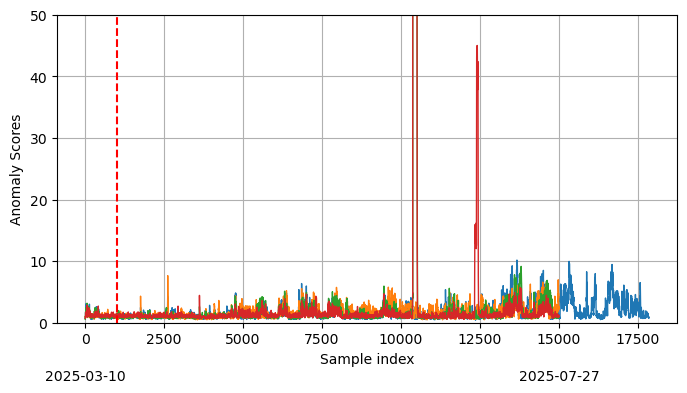

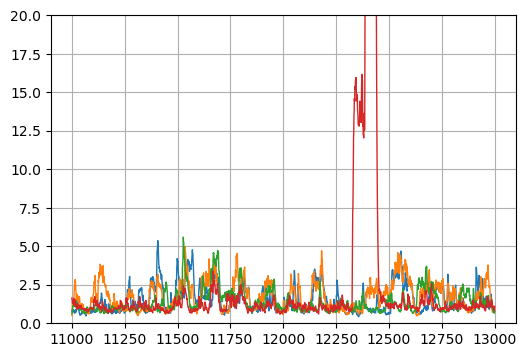

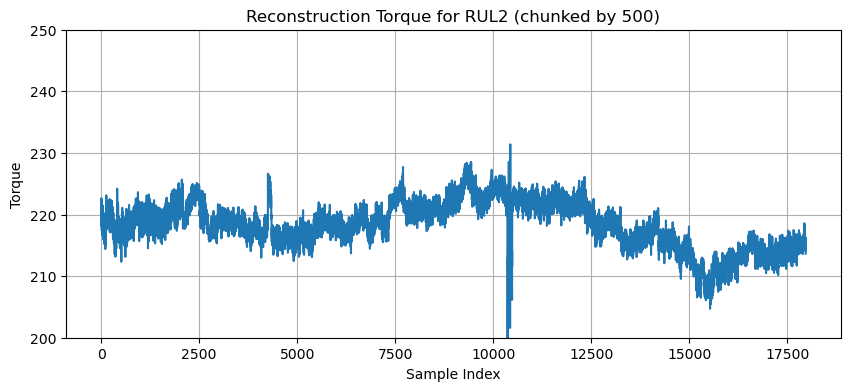

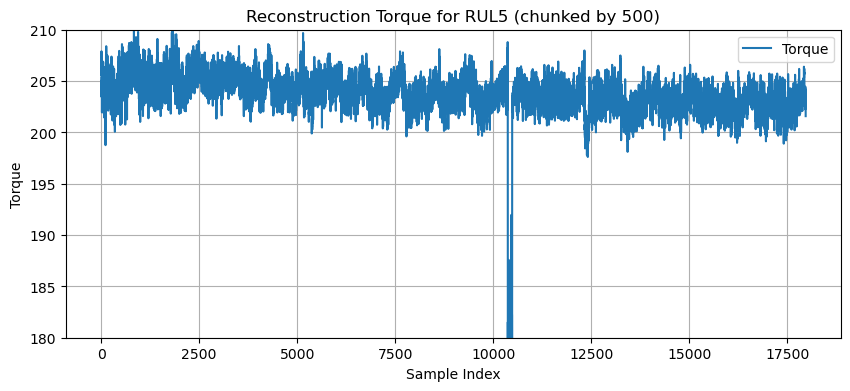

2025-06-22 18:59:21


In [22]:
import pandas as pd
import datetime
def exponential_smoothing(series, alpha):
    smoothed = np.zeros_like(series)
    smoothed[0] = series[0]
    for t in range(1, len(series)):
        smoothed[t] = alpha * series[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# rul5_MD = np.concatenate(rul5_rul5_MD)
torque_array_rul5 = np.concatenate(rul5_torque)
torque_array_rul2 = np.concatenate(rul2_torque)
print(len(torque_array_rul5))
print(len(torque_array_rul2))

# 取出大於20的idx並將其去除
# rul2 
rul5_MD_VI = np.concatenate(rul5_rul5_MD_VI)
idx_valid_rul5 = np.where(rul5_MD_VI <= 100)[0]
rul5_MD_VI_filtered = rul5_MD_VI[idx_valid_rul5]
rul5_MD_II_filtered = np.concatenate(rul5_rul5_MD_II)[idx_valid_rul5]
#  no filter check
rul5_MD_VI_filtered = rul5_MD_VI
rul5_MD_II_filtered =np.concatenate(rul5_rul5_MD_II)

torque_array_rul5_filtered = torque_array_rul5[idx_valid_rul5]

# rul2
rul2_MD_VI = np.concatenate(rul2_rul2_MD_VI)
idx_valid_rul2 = np.where(rul2_MD_VI <= 100)[0]
rul2_MD_VI_filtered = rul2_MD_VI[idx_valid_rul2]
rul2_MD_II_filtered = np.concatenate(rul2_rul2_MD_II)[idx_valid_rul2]
torque_array_rul2_filtered = torque_array_rul2[idx_valid_rul2]



alpha=0.2
# 繪圖
check_start=0
check_end=15000
check_end=min(check_end, len(rul5_MD_VI_filtered), len(rul2_MD_VI_filtered))
df_start=read_rul_data_PEWC(rul5_files[check_start])
df_end=read_rul_data_PEWC(rul5_files[check_end])

fig, ax = plt.subplots(figsize=(8, 4))

# 繪圖
alpha=0.2
ax.plot(exponential_smoothing((rul2_MD_II_filtered)[check_start:], alpha=alpha), label='RUL2 MD II', linewidth=1)
ax.plot(exponential_smoothing((rul2_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL2 MD VI', linewidth=1)
ax.plot(exponential_smoothing((rul5_MD_II_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD II', linewidth=1)
ax.plot(exponential_smoothing((rul5_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD VI', linewidth=1)
ax.axvline(x=training_file_numbers, color='red', linestyle='--', label='End of RUL5 data')
ax.set_xlabel('Sample index')
ax.set_ylabel('Anomaly Scores')

# 轉換開始與結束時間
start_time_dt = datetime.datetime.fromtimestamp(float(df_start['Unix Time']))
end_time_dt = datetime.datetime.fromtimestamp(float(df_end['Unix Time']))

# 在 x 軸刻度標籤的正下方標註日期
ax.text(0, -0.15, start_time_dt.strftime('%Y-%m-%d'),
        ha='center', va='top', transform=ax.get_xaxis_transform())
ax.text(check_end - check_start - 1, -0.15, end_time_dt.strftime('%Y-%m-%d'),
        ha='center', va='top', transform=ax.get_xaxis_transform())

# ax.legend()
ax.grid(True)
ax.set_ylim(0, 50)  # 設定 y 軸範圍
plt.savefig(os.path.join('TIE_plots','PEWC_EVCC.png'), dpi=300, bbox_inches='tight')
plt.show()



check_start=11000
check_end=13000
fig, ax = plt.subplots(figsize=(6, 4))

# zoom in 
alpha=0.2
ax.plot(range(check_start, check_end),exponential_smoothing( (rul2_MD_II_filtered)[check_start:check_end], alpha=alpha), label='RUL2 MD II', linewidth=1)
ax.plot(range(check_start, check_end),exponential_smoothing( (rul2_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL2 MD VI', linewidth=1)
ax.plot(range(check_start, check_end),exponential_smoothing( (rul5_MD_II_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD II', linewidth=1)
ax.plot(range(check_start, check_end),exponential_smoothing( (rul5_MD_VI_filtered)[check_start:check_end], alpha=alpha), label='RUL5 MD VI', linewidth=1)

# ax.legend()
ax.grid(True)
ax.set_ylim(0, 20)  # 設定 y 軸範圍
# plt.savefig(os.path.join('TIE_plots', 'PEWC_EVCC_zoomin.emf'), format='emf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10, 4))
plt.plot(np.concatenate(rul2_torque), label='Torque')
plt.xlabel('Sample Index')
plt.ylabel('Torque')
plt.title('Reconstruction Torque for RUL2 (chunked by 500)')
# plt.legend()
plt.grid(True)
plt.ylim(200, 250)  # 設定 y 軸範圍
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(torque_array_rul5, label='Torque')
plt.xlabel('Sample Index')
plt.ylabel('Torque')
plt.title('Reconstruction Torque for RUL5 (chunked by 500)')
plt.legend()
plt.grid(True)
plt.ylim(180, 210)  # 設定 y 軸範圍
plt.show()
df_check=read_rul_data_PEWC(rul5_files[12250])
print(datetime.datetime.fromtimestamp(float(df_check['Unix Time'])))

(0.0, 0.005)

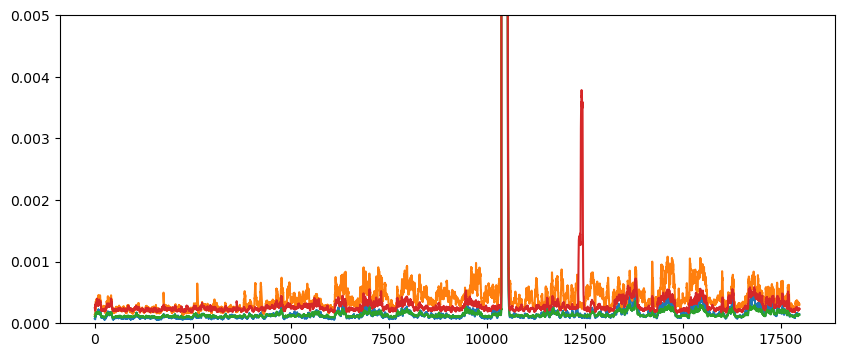

In [ ]:
rul2_mse_all_VI_np=np.concatenate(rul2_mse_all_VI)
rul2_mse_all_II_np=np.concatenate(rul2_mse_all_II)
rul5_mse_all_VI_np=np.concatenate(rul5_mse_all_VI)
# 每五筆取一次平均
def average_every_n(arr, n=5):
    usable_len = (len(arr) // n) * n
    return np.mean(arr[:usable_len].reshape(-1, n), axis=1)
rul2_mse_all_VI_np=np.concatenate(rul2_mse_all_VI)
rul2_mse_all_II_np=np.concatenate(rul2_mse_all_II)
rul5_mse_all_VI_np=np.concatenate(rul5_mse_all_VI)
rul5_mse_all_II_np=np.concatenate(rul5_mse_all_II)
rul2_mse_all_VI_avg = average_every_n(rul2_mse_all_VI_np[:,0], n=5)
rul2_mse_all_II_avg = average_every_n(rul2_mse_all_II_np[:,0], n=5)
rul5_mse_all_VI_avg = average_every_n(rul5_mse_all_VI_np[:,0], n=5)
rul5_mse_all_II_avg = average_every_n(rul5_mse_all_II_np[:,0], n=5)


plt.close('all')
plt.figure(figsize=(10, 4))

plt.plot(exponential_smoothing( (rul2_mse_all_II_avg), alpha=alpha), label='RUL2 MSE II')
plt.plot(exponential_smoothing( (rul2_mse_all_VI_avg), alpha=alpha), label='RUL2 MSE VI')
plt.plot(exponential_smoothing( (rul5_mse_all_II_avg), alpha=alpha), label='RUL5 MSE II')
plt.plot(exponential_smoothing( (rul5_mse_all_VI_avg), alpha=alpha), label='RUL5 MSE VI')

plt.savefig(os.path.join('TIE_plots','EVCC_MSE.png'), dpi=300, bbox_inches='tight')
plt.ylim(0, 0.005)

1/1 [==============================] - 0s 35ms/step
(512,)
(1, 512, 2)
(1, 512, 2)
1/1 [==============================] - 0s 39ms/step
(512,)
(1, 512, 2)
(1, 512, 2)


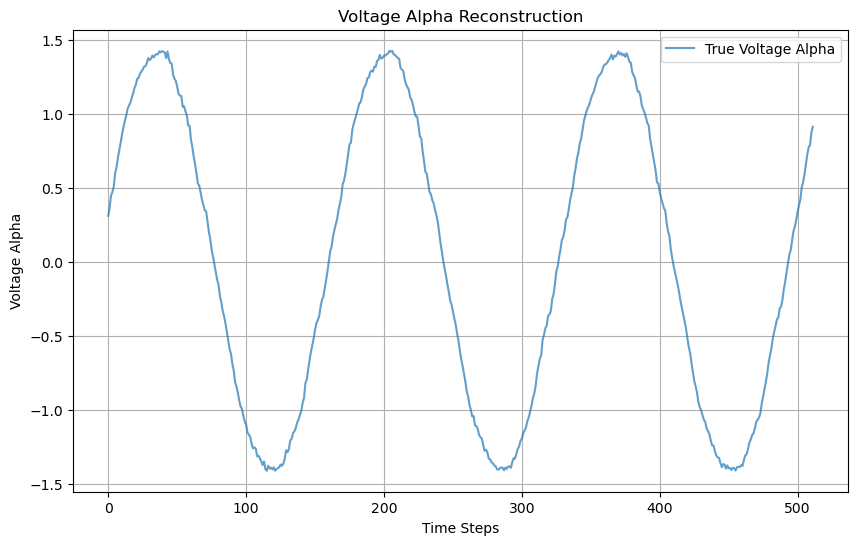

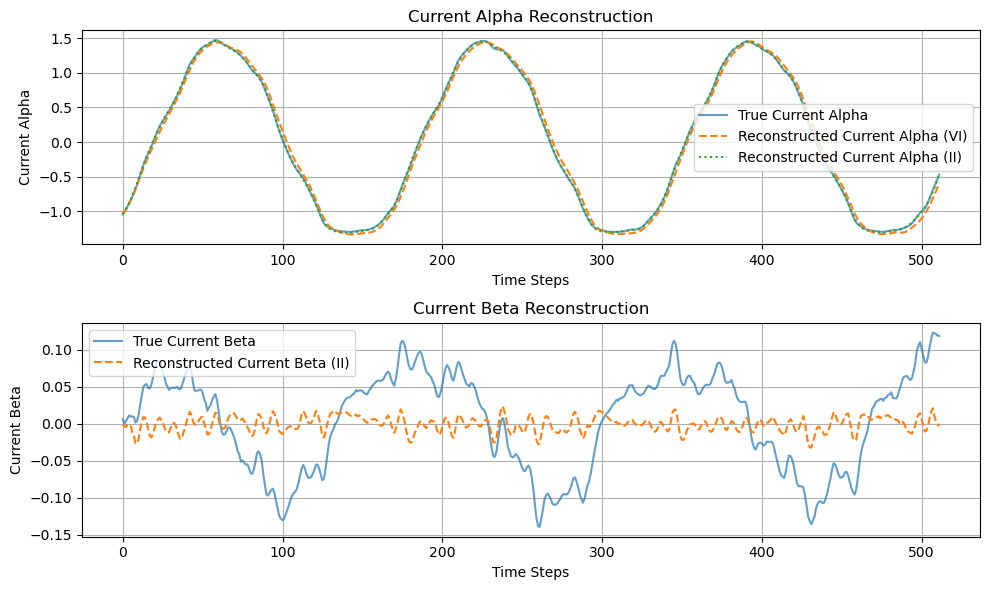

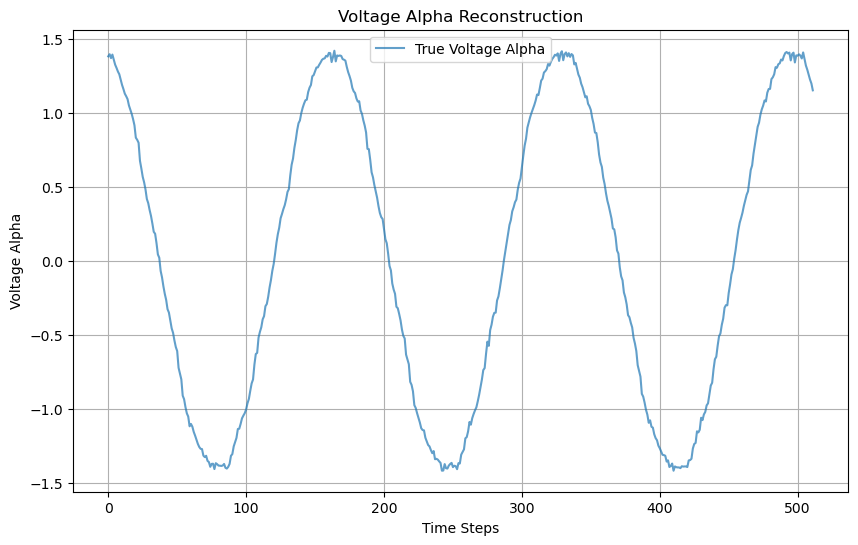

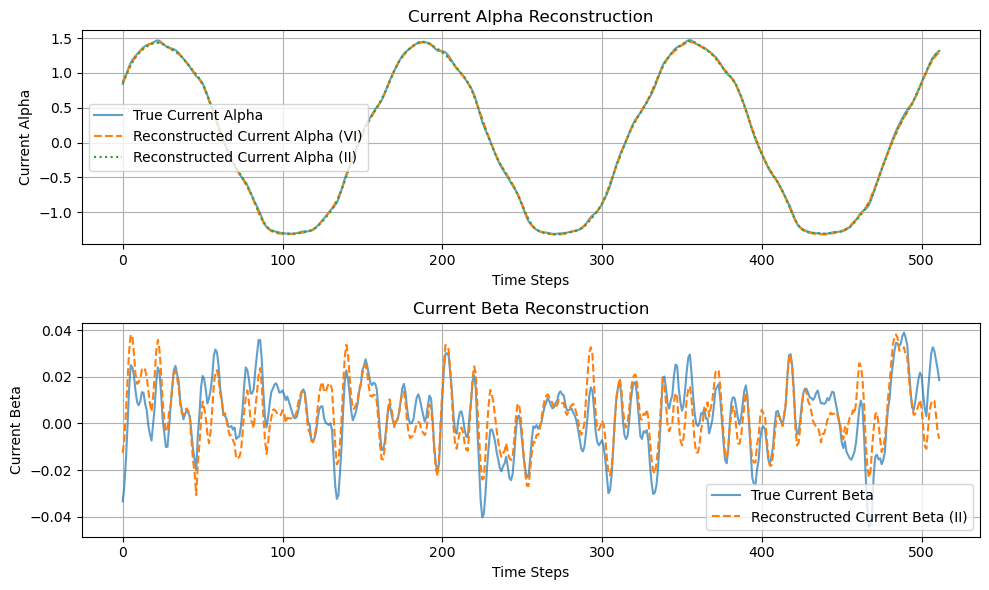

In [ ]:
def plot_reconstruction_file(file, modelVI, modelII):
    df=read_rul_data_PEWC(file)
    df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2 
    torque, _, _, v_alpha, v_beta, power_sts = estimate_torque(df, debug=False) 
    voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
    voltage_beta= np.array(df["Voltage beta"]).squeeze()
    current_alpha= np.array(df["Current alpha"]).squeeze()
    current_beta= np.array(df["Current beta"]).squeeze()
    if len(torque) > 2500:
        if len(torque) == 4000:
            torque_avg = np.mean(np.abs(torque[-2000:]))
        else :
            torque_avg = np.mean(np.abs(torque[2250:2500]))
    else:
        torque_avg = np.mean(np.abs(torque[-500:]))
    temp_train_signals=[voltage_alpha, 
                                voltage_beta,
                                current_alpha,
                                current_beta]
    temp_train_signals_normalized = []
    
    # 將數據標準化（均值為 0，標準差為 1）
    for signal in temp_train_signals:
        mean = np.mean(signal)
        std = np.std(signal)
        # 避免除以零的狀況（std == 0）
        if std == 0:
            standardized = np.zeros_like(signal)
        else:
            standardized = (signal - mean) / std
        temp_train_signals_normalized.append(standardized)
        
    temp_train_signals = np.stack(temp_train_signals, axis=1)
    temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
    torque_array = np.ones((1, 1)) * torque_avg
    temp_train_signals = temp_train_signals[np.newaxis, -sequence_length:, :].astype(np.float32)
    temp_train_signals_normalized = temp_train_signals_normalized[np.newaxis, -sequence_length:, :].astype(np.float32)
    past_voltages=temp_train_signals[:, :, 0:2]
    past_currents=temp_train_signals[:, :, 2:4]
    past_voltages_normalized=temp_train_signals_normalized[:, :, 0:2]
    past_currents_normalized=temp_train_signals_normalized[:, :, 2:4]
    torque_array = torque_array.astype(np.float32)
    # 推論
    reconstruction_VI= modelVI.predict([past_voltages_normalized,
                                                torque_array,
                                                torque_array], batch_size=1)
    reconstruction_II= modelII.predict([past_currents_normalized,
                                                torque_array,
                                                torque_array], batch_size=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(past_voltages_normalized[0,-sequence_length:, 0], label='True Voltage Alpha', alpha=0.7)
    plt.xlabel('Time Steps')
    plt.ylabel('Voltage Alpha')
    plt.title('Voltage Alpha Reconstruction')
    plt.legend()
    plt.grid(True)
    
    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
    plt.plot(past_currents_normalized[0,-sequence_length:, 0], label='True Current Alpha', alpha=0.7)
    plt.plot(reconstruction_VI[0,:,0], label='Reconstructed Current Alpha (VI)', linestyle='--')
    plt.plot(reconstruction_II[0,:,0], label='Reconstructed Current Alpha (II)', linestyle=':')
    plt.xlabel('Time Steps')
    plt.ylabel('Current Alpha')
    plt.title('Current Alpha Reconstruction')
    plt.legend()
    plt.grid(True)

    plt.subplot(2,1,2)
    print(past_currents_normalized[0,-sequence_length:, 0].squeeze().shape)
    print(past_currents_normalized.shape)
    print(reconstruction_VI.shape)
    reconstruction_err_VI=past_currents_normalized-reconstruction_VI
    reconstruction_err_II=past_currents_normalized-reconstruction_II
    plt.plot(reconstruction_err_VI[:,:,0].squeeze(), label='True Current Beta', alpha=0.7)
    plt.plot(reconstruction_err_II[:,:,0].squeeze(), label='Reconstructed Current Beta (II)', linestyle='--')


    plt.xlabel('Time Steps')
    plt.ylabel('Current Beta')
    plt.title('Current Beta Reconstruction')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    
plt.close('all')    
plot_reconstruction_file(rul5_files[12430], my_model_V_in_I_out_PEWC_rul5, my_model_I_in_I_out_PEWC_rul5)
plot_reconstruction_file(rul5_files[12280], my_model_V_in_I_out_PEWC_rul5, my_model_I_in_I_out_PEWC_rul5)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_fft_shift(signal, Fs=10000):
    """
    計算複數訊號的 FFT，並回傳 shift 後的頻率、振幅、相位
    Parameters:
        signal: 1D numpy array (complex or real)
        Fs: 取樣頻率 (Hz)，若提供則頻率以 Hz 回傳
    Returns:
        freqs_shift: 頻率 (shift 後, 若 Fs 提供則為 Hz)
        fft_mag_shift: 振幅 (shift 後)
        fft_phase_shift: 相位 (shift 後)
    """
    N = len(signal)
    fft_complex = np.fft.fft(signal)
    if Fs is not None:
        freqs = np.fft.fftfreq(N, d=1/Fs)
    else:
        freqs = np.fft.fftfreq(N)
    fft_complex_shift = np.fft.fftshift(fft_complex)
    freqs_shift = np.fft.fftshift(freqs)
    fft_mag_shift = np.abs(fft_complex_shift)
    fft_phase_shift = np.angle(fft_complex_shift)
    return freqs_shift, fft_mag_shift/ N, fft_phase_shift

def compute_fft_real(signal, Fs=10000):
    """
    計算實數訊號的 FFT，並回傳頻率、振幅、相位
    Parameters:
        signal: 1D numpy array (real)
        Fs: 取樣頻率 (Hz)，若提供則頻率以 Hz 回傳
    Returns:
        freqs: 頻率 (Hz, 只包含非負頻率)
        fft_mag: 振幅
        fft_phase: 相位
    """
    N = len(signal)
    # 只計算非負頻率的 FFT
    fft_complex = np.fft.rfft(signal)
    if Fs is not None:
        freqs = np.fft.rfftfreq(N, d=1/Fs)
    else:
        freqs = np.fft.rfftfreq(N)

    fft_mag = np.abs(fft_complex)*2 # 乘以 2 以補償 rfft 的能量損失
    fft_phase = np.angle(fft_complex)

    return freqs, fft_mag/ N, fft_phase


def reconstruct_equal_interval(segments, original_length, sequence_length):
    """
    將等距切分後（並可能經 AE 重建）的片段，依原始切分規則拼回原始長度。

    參數
    ----
    segments : np.ndarray
        shape = (num_samples, sequence_length, d)
        每個片段（可已被 AE 重建）——形狀需與切分時一致。
    original_length : int
        原始訊號長度 N（例如 5000）。
    sequence_length : int
        當初切分時的視窗長度（例如 1024）。

    回傳
    ----
    reconstructed : np.ndarray
        shape = (original_length, d)
        還原後的完整序列；重疊區已做平均。
    """
    if sequence_length <= 0:
        raise ValueError("sequence_length 必須為正整數")

    num_samples, seq_len_chk, d = segments.shape
    if seq_len_chk != sequence_length:
        raise ValueError("segments 的第二維必須等於 sequence_length")

    if original_length < sequence_length:
        raise ValueError("original_length 必須 >= sequence_length")

    # 與切分函式一致的可切起點上限
    max_possible = original_length - sequence_length + 1

    if num_samples <= 0:
        raise ValueError("segments 的 num_samples 必須 > 0")
    if num_samples > max_possible:
        # 切回時也要守住上限（理論上不該發生；保險起見）
        raise ValueError("num_samples 超過當初可切的上限，請確認參數是否一致")

    # 產生等距起點（與 data_interval_augmentation 完全對齊）
    if num_samples == 1:
        start_indices = np.array([0], dtype=int)
    else:
        step = (max_possible - 1) / (num_samples - 1)
        start_indices = np.round(np.arange(num_samples) * step).astype(int)
        start_indices = np.clip(start_indices, 0, max_possible - 1)

    # 配置輸出與計數（用於重疊平均）
    reconstructed = np.zeros((original_length, d), dtype=segments.dtype)
    counts = np.zeros((original_length, 1), dtype=np.int32)

    # 貼回並累加
    for seg, start in zip(segments, start_indices):
        end = start + sequence_length
        reconstructed[start:end] += seg
        counts[start:end] += 1

    # 重疊區平均（避免除以 0）
    counts[counts == 0] = 1
    reconstructed = reconstructed / counts

    return reconstructed



my_model_V_in_I_out_PEWC_rul5=load_model(os.path.join(model_path, model_name + '_VI_rul5.keras'))

all_fft_rul5=[]
all_fft_real_rul5=[]

all_fft_err_rul5=[]
all_fft_reconstruction_rul5=[]

start_file_idx=11000+110
end_file_idx=11000+3000+110
print(f'process data from {start_file_idx} to {end_file_idx}...')
for i in range(start_file_idx, end_file_idx):
    df=read_rul_data_PEWC(rul5_files[i])
    df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2

    voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
    voltage_beta= np.array(df["Voltage beta"]).squeeze()
    current_alpha= np.array(df["Current alpha"]).squeeze()
    current_beta= np.array(df["Current beta"]).squeeze()
    
    # 合併測試資料至訓練維度 shape=(,4000,dim)
    temp_train_signals=[voltage_alpha, 
                                voltage_beta,
                                current_alpha,
                                current_beta]
    
    temp_train_signals_normalized = []
    
    # 將數據標準化（均值為 0，標準差為 1）
    for signal in temp_train_signals:
        mean = np.mean(signal)
        std = np.std(signal)
        # 避免除以零的狀況（std == 0）
        if std == 0:
            standardized = np.zeros_like(signal)
        else:
            standardized = (signal - mean) / std
        temp_train_signals_normalized.append(standardized)
        
   
    
    temp_train_signals = np.stack(temp_train_signals, axis=1)
    temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
    
         
    temp_train_input_signals_augmented = data_interval_augmentation(
            temp_train_signals_normalized, 512, 
            augmen_sample_number=10, future_length=future_length
        )
    reconstructed_current = my_model_V_in_I_out_PEWC_rul5.predict(
                    [temp_train_input_signals_augmented[:, :, 0:2], 
                    temp_train_input_signals_augmented[:, None,None], 
                    temp_train_input_signals_augmented[:, None,None],],
                    verbose=0
                )
    reconstructed_current=reconstruct_equal_interval(
        reconstructed_current, 
        original_length=len(current_alpha), 
        sequence_length=512
    )
    
    reconstructed_current_err=temp_train_signals_normalized[:,2:4]-reconstructed_current


    freqs_shift, fft_mag_shift_normal1, _ = compute_fft_shift(temp_train_signals_normalized[:,2] + 1j * temp_train_signals_normalized[:,3])
    freqs, fft_mag,_= compute_fft_real(temp_train_signals_normalized[:,2])
    all_fft_rul5.append(fft_mag_shift_normal1)
    all_fft_real_rul5.append(fft_mag)
    all_fft_reconstruction_rul5.append(compute_fft_real(reconstructed_current[:,0])[1])
    all_fft_err_rul5.append(compute_fft_real(reconstructed_current_err[:,0])[1])



all_fft_rul5_np=np.array(all_fft_rul5)
all_fft_real_rul5_np=np.array(all_fft_real_rul5)
all_fft_err_rul5_np=np.array(all_fft_err_rul5)
all_fft_reconstruction_rul5_np=np.array(all_fft_reconstruction_rul5)

# plt.imshow(20 * np.log10(all_fft_real_rul5_np.transpose() + 1e-12), aspect='auto', origin='lower', cmap='viridis')


process data from 11110 to 14110...


(3000, 4000)
(3000, 2001)
(3000, 2001)
(3000, 2001)
(4000, 2)
(4000, 2)


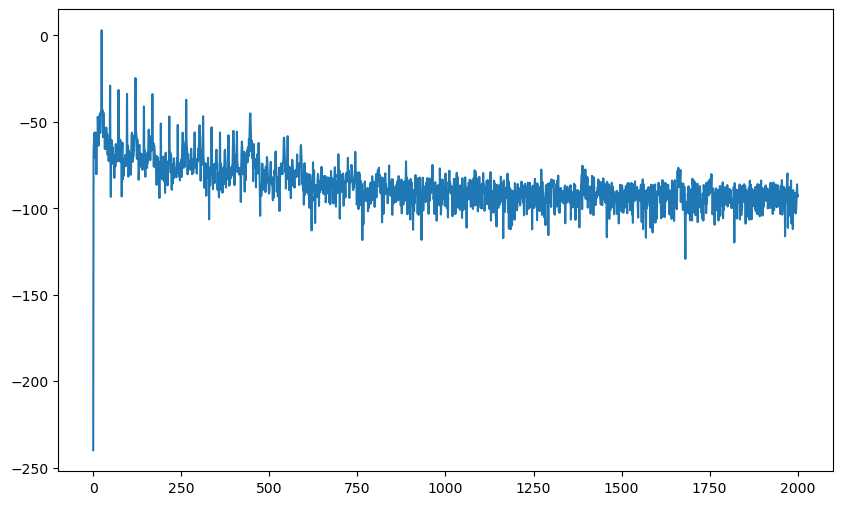

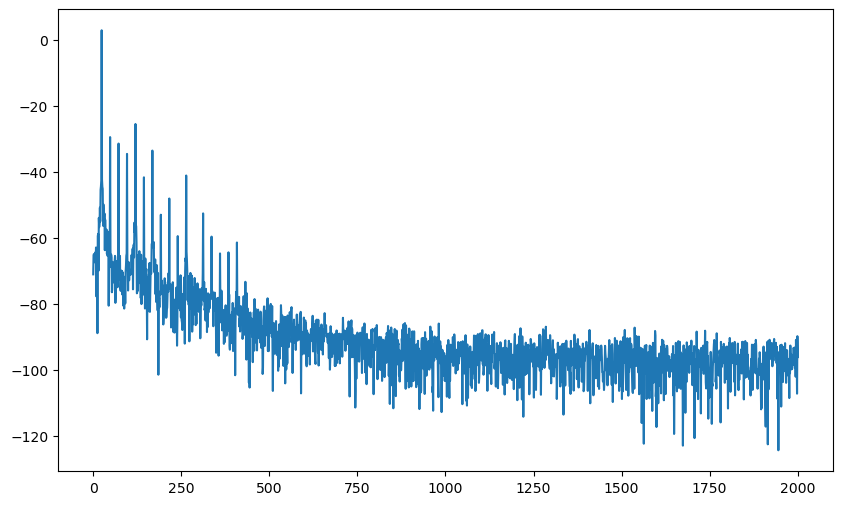

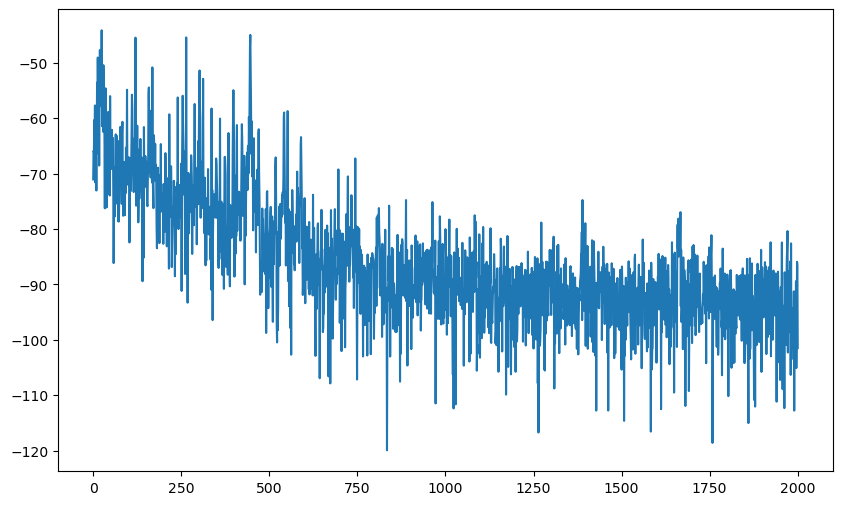

In [ ]:
print(all_fft_rul5_np.shape)
print(all_fft_real_rul5_np.shape)
print(all_fft_err_rul5_np.shape)
print(all_fft_reconstruction_rul5_np.shape)
print(reconstructed_current.shape)
print(reconstructed_current_err.shape)

plt.figure(figsize=(10, 6))
plt.plot(20*np.log10(all_fft_real_rul5_np[0,:]+ 1e-12))

plt.figure(figsize=(10, 6))
plt.plot(20*np.log10(all_fft_reconstruction_rul5_np[0,:] + 1e-12))


plt.figure(figsize=(10, 6))
plt.plot(20*np.log10(all_fft_err_rul5_np[0,:] + 1e-12))

# plt.plot(reconstructed_current_err[:,0])

# temp_train_signals_normalized[:,2:4]-reconstructed_current

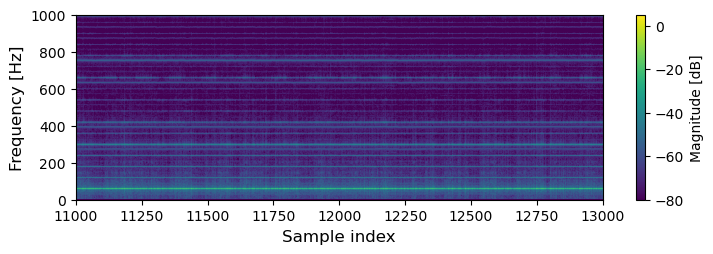

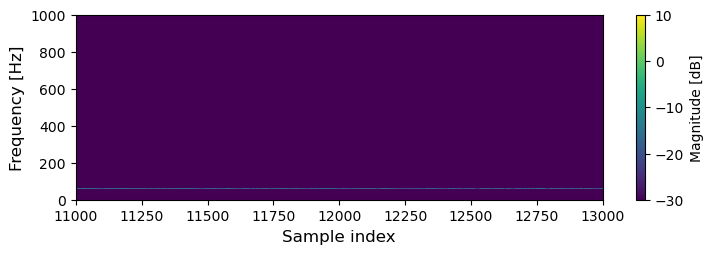

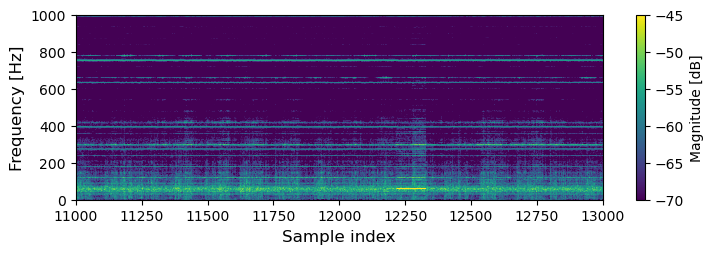

In [ ]:
start_file_idx=11000
end_file_idx=11000+3000
plt.figure(figsize=(8.5, 2.4))
plt.imshow(
    20*np.log10(all_fft_real_rul5_np.transpose() + 1e-12),
    aspect='auto',
    origin='lower',
    extent=[ start_file_idx, end_file_idx, freqs.min(), freqs.max()],  # x: 頻率, y: 樣本編號(1~10)
    vmin=-80, vmax=5   # <<--- 指定顏色範圍
)
plt.ylim(0,1000)
plt.xlim(start_file_idx, 13000)
# db_data = 20 * np.log10(all_fft_real_rul5_np.transpose() + 1e-12)
# print(db_data.min(), db_data.max())

plt.colorbar(label="Magnitude [dB]")
plt.xlabel("Sample index", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)
plt.show()


plt.figure(figsize=(8.5, 2.4))
plt.imshow(
    20*np.log10(all_fft_reconstruction_rul5_np.transpose()*2 + 1e-12),
    aspect='auto',
    origin='lower',
    extent=[ start_file_idx, end_file_idx, freqs.min(), freqs.max()],  # x: 頻率, y: 樣本編號(1~10)
    vmin=-30, vmax=10   # <<--- 指定顏色範圍
)
plt.ylim(0,1000)
plt.xlim(start_file_idx, 13000)

# db_data = 20 * np.log10(all_fft_real_rul5_np.transpose() + 1e-12)
# print(db_data.min(), db_data.max())

plt.colorbar(label="Magnitude [dB]")
plt.xlabel("Sample index", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)
plt.show()

plt.figure(figsize=(8.5, 2.4))
plt.imshow(
    20*np.log10(all_fft_err_rul5_np.transpose() + 1e-12),
    aspect='auto',
    origin='lower',
    extent=[ start_file_idx, end_file_idx, freqs.min(), freqs.max()],  # x: 頻率, y: 樣本編號(1~10)
    vmin=-70, vmax=-45   # <<--- 指定顏色範圍
)
plt.ylim(0,1000)
plt.xlim(start_file_idx, 13000)
# db_data = 20 * np.log10(all_fft_real_rul5_np.transpose() + 1e-12)
# print(db_data.min(), db_data.max())

plt.colorbar(label="Magnitude [dB]")
plt.xlabel("Sample index", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)
plt.show()

雙軸電流誤差計算

In [ ]:
print(np.where(rul5_MD_VI >= 100)[0][0])
print(np.where(rul5_MD_VI >= 100)[0][-1])
np.where(rul5_MD_VI >= 100)[0][-1]-np.where(rul5_MD_VI >= 100)[0][0]

10370
10480


110

(3000, 2001)

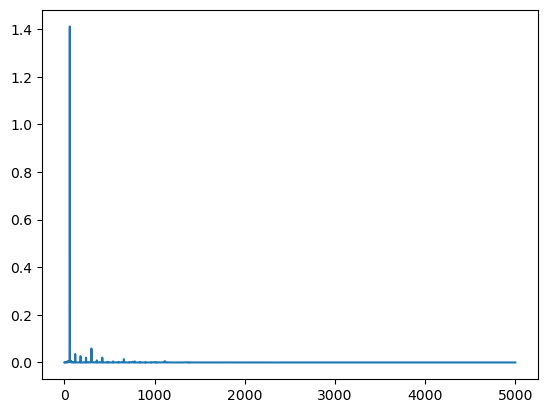

In [ ]:
plt.figure()
plt.plot(freqs, (all_fft_real_rul5_np[0,:] + 1e-12))
# plt.plot(temp_train_signals_normalized[:,2])
all_fft_real_rul5_np.shape

In [ ]:
# 計算重建殘差
# 以 one_test_batch_files 個檔案維一個資料集分析變化

# 儲存重建誤差值
reconstruction_errs_batches_ab = [] # 以batch 儲存重建誤差原始值(每一元素為該批次資料之原始重建誤差)
reconstruction_mse_batches_ab=[]# 儲存重建誤差mse(每一點為該批次資料之mse)
for start_idx in range(0, test_input_augmented.shape[0], data_per_test_bartch):
    end_idx=start_idx + data_per_test_bartch
    reconstruc_err_per_batch_alpha=test_input_augmented[start_idx:end_idx,:,0:1] - (test_results[0][start_idx:end_idx,:])
    reconstruc_err_per_batch_beta=test_input_augmented[start_idx:end_idx,:,1:2] - (test_results[1][start_idx:end_idx,:])
    reconstruc_err_per_batch = np.concatenate((reconstruc_err_per_batch_alpha, reconstruc_err_per_batch_beta), axis=1)
    reconstruction_errs_batches_ab.append(reconstruc_err_per_batch)
    
    # 將批次誤差一維化並聚攏，方便計算最終mse值
    flattened_batch_err= np.array(reconstruc_err_per_batch).flatten()
    reconstruction_mse_batches_ab.append(np.mean(np.square(flattened_batch_err)))

NameError: name 'test_input_augmented' is not defined

In [ ]:

# 對 reconstruction_mse_batches_ab 做指數平滑
def exponential_smoothing(data, alpha=0.1):
    smoothed = [data[0]]
    for v in data[1:]:
        smoothed.append(alpha * v + (1 - alpha) * smoothed[-1])
    return smoothed

reconstruction_mse_batches_ab_smooth = exponential_smoothing(reconstruction_mse_batches_ab, alpha=0.1)
# # 繪製重建殘差
plt.figure()

plt.plot( reconstruction_mse_batches_ab, label='Reconstruction Error')
plt.plot( reconstruction_mse_batches_ab_smooth, label='Reconstruction Error')
plt.xlabel('Time Steps')
plt.ylabel('Error')

IndexError: list index out of range

Save the prediction result

In [ ]:
import pickle
from datetime import datetime

epochs=10
batch_size=100

model_type = 'I2_in_I2_out'

prediction_results = {
    "Model_type": model_type,
    "Model_name": model_save_name,
    "Input_type": "alpha_beta",
    "Output_type": "alpha_beta",
    "Training_info": {
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": "adam",
        "loss": "mse",
    },
    "Evaluation": {
        "reconstruction_errs_batches_alpha": reconstruction_errs_batches_ab,
        "reconstruction_mse_batches": reconstruction_mse_batches_ab,
    },
    "Timestamps": {
        "saved_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

result_save_path=os.path.join(model_saved_path, f"{model_type}_results.pkl")
with open(result_save_path, "wb") as f:
    pickle.dump(prediction_results, f)


NameError: name 'model_save_name' is not defined